In [5]:
import os
import subprocess
import itertools
import csv
from datetime import datetime

# === Session Details ===
animal = "20241224PMCLE1"
session_dir = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope"

# === Parameter Grid Setup ===
wnd_size_vals    = [700, 1500]
stp_size_vals    = [700]  # Only one value
diff_thres_vals  = [3.5, 4.0, 5.0]
pnr_thresh_vals  = [1.1, "auto"]

# Determine max_wnd_vals based on session_dir.
# If "pmc" appears in the path, use 15; if "v1" appears, use 25; otherwise default to 25.
if "pmc" in session_dir.lower():
    max_wnd_vals = [15]
elif "v1" in session_dir.lower():
    max_wnd_vals = [25]
else:
    max_wnd_vals = [25]

# === Log File Setup ===
log_file = os.path.join(session_dir, "param_search_log.csv")
if not os.path.exists(log_file):
    with open(log_file, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["timestamp", "combination", "wnd_size", "stp_size", "max_wnd", "diff_thres", "pnr_thresh", "result_file"])

# === Complete Parameter File Template ===
param_template = r"""
import os
import numpy as np
import pathlib
# import datetime

param_seeds_init = {{
    'wnd_size': {wnd_size},  # window size
    'method': 'rolling',
    'stp_size': {stp_size},  # step size
    'max_wnd': {max_wnd},    # maximum window (set based on session type)
    'diff_thres': {diff_thres}  # difference threshold
}}

param_denoise = {{"method": "median", "ksize": 5}}
param_background_removal = {{"method": "tophat", "wnd": 15}}
noise_freq = 0.01
sparse_penal = 0.01

param_pnr_refine = {{"noise_freq": noise_freq, "thres": {pnr_thresh} }}  # try 1.1 or "auto"
param_ks_refine = {{"sig": 0.05}}
param_seeds_merge = {{"thres_dist": 10, "thres_corr": 0.8, "noise_freq": 0.01}}
param_initialize = {{"thres_corr": 0.8, "wnd": 10, "noise_freq": 0.01}}
param_init_merge = {{"thres_corr": 0.8}}

# CNMF Parameters#
param_get_noise = {{"noise_range": (0.01, 0.5)}}
param_first_spatial = {{
    "dl_wnd": 10,
    "sparse_penal": sparse_penal,  # remains at 0.01
    "size_thres": (25, None),
}}

param_first_merge = {{"thres_corr": 0.8}}

minian_path = "/home/lq53/mir_repos/minian/minian"

dpath = os.path.dirname(pathlib.Path(__file__).resolve())
minian_ds_path = os.path.join(dpath, "minian")
intpath = os.path.join(dpath, "minian_intermediate")
nc_file_name = os.path.join(dpath, "minian_dataset_{unique_id}.nc")

subset = dict(frame=slice(0, None))
subset_mc = None
interactive = True
output_size = 100
n_workers = int(os.getenv("MINIAN_NWORKERS", 4))
param_save_minian = {{
    "dpath": minian_ds_path,
    "meta_dict": dict(session=-1, animal=-2),
    "overwrite": True,
}}

param_load_videos = {{
    "pattern": "[0-9]+\.avi$",
    "dtype": np.uint8,
    "downsample": dict(frame=1, height=1, width=1),
    "downsample_strategy": "subset",
}}

subset_mc = None
param_estimate_motion = {{"dim": "frame"}}

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MINIAN_INTERMEDIATE"] = intpath
"""

# === Grid Search Loop ===
for wnd_size, stp_size, max_wnd, diff_thres, pnr_thresh in itertools.product(
    wnd_size_vals, stp_size_vals, max_wnd_vals, diff_thres_vals, pnr_thresh_vals
):
    # Format the pnr_thresh value properly for Python syntax.
    if isinstance(pnr_thresh, str):
        pnr_thresh_str = f'"{pnr_thresh}"'
    else:
        pnr_thresh_str = pnr_thresh

    combination_str = f"wnd{wnd_size}_stp{stp_size}_max{max_wnd}_diff{diff_thres}_pnr{pnr_thresh}"
    print(f"Running combination: {combination_str}")
    
    # Generate parameter file content for the current combination.
    param_content = param_template.format(
        wnd_size=wnd_size,
        stp_size=stp_size,
        max_wnd=max_wnd,
        diff_thres=diff_thres,
        pnr_thresh=pnr_thresh_str,
        unique_id=combination_str
    )
    
    # Write the temporary parameter file in the session directory.
    param_file_path = os.path.join(session_dir, "minian_param_mir.py")
    with open(param_file_path, "w") as f:
        f.write(param_content)
    
    # Execute the main processing script in the session directory.
    result = subprocess.run(["python", "minian_mirpy_set.py"], cwd=session_dir, capture_output=True, text=True)
    print(result.stdout)
    if result.stderr:
        print("Errors:", result.stderr)
    
    # Determine the expected output file based on the unique identifier.
    output_nc = os.path.join(session_dir, f"minian_dataset_{combination_str}.nc")
    if not os.path.exists(output_nc):
        print(f"Warning: Output file not found for combination {combination_str}.")
        output_nc = "Not produced"
    
    # Log the parameter combination and result.
    timestamp = datetime.now().isoformat()
    with open(log_file, "a", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([timestamp, combination_str, wnd_size, stp_size, max_wnd, diff_thres, pnr_thresh, output_nc])
    
    # Optional: Add a delay here if needed (e.g., time.sleep(10))



#below is too many param version that i abandon
# import os
# import subprocess
# import itertools
# import csv
# from datetime import datetime

# # === Session Details ===
# animal = "20241224PMCLE1"
# session_dir = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope"

# # === Parameter Grid ===
# wnd_size_vals   = [700, 1000, 1500]
# stp_size_vals   = [300, 500, 700]
# max_wnd_vals    = [15, 18, 21, 25]
# diff_thres_vals = [3.5, 4.0, 5.0]

# # === Log File Setup ===
# log_file = os.path.join(session_dir, "param_search_log.csv")
# if not os.path.exists(log_file):
#     with open(log_file, "w", newline="") as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(["timestamp", "combination", "wnd_size", "stp_size", "max_wnd", "diff_thres", "result_file"])

# # === Complete Parameter File Template ===
# # Use placeholders for the seed parameters and the output file unique identifier.
# param_template = r"""
# import os
# import numpy as np
# import pathlib
# # import datetime

# # param_seeds_init['max_wnd']= 25 #25 good for V1. default 15, the maxium size of a neuron, which should zoom in and briefly determine
# param_seeds_init = {{
#     'wnd_size': {wnd_size},  # {wnd_size}, smaller windows would potential generate more seeds, so maybe would have included some potential neurons.
#     'method': 'rolling',
#     'stp_size': {stp_size},  # {stp_size}
#     'max_wnd': {max_wnd},    # {max_wnd} works well for V1. now trying 15 for PMC
#     'diff_thres': {diff_thres}  # {diff_thres}, 6
# }}

# param_denoise = {{"method": "median", "ksize": 5}}
# param_background_removal = {{"method": "tophat", "wnd": 15}}
# noise_freq = 0.02
# sparse_penal = 0.01

# param_pnr_refine = {{"noise_freq": noise_freq, "thres": 1.1}}
# param_ks_refine = {{"sig": 0.05}}
# param_seeds_merge = {{"thres_dist": 10, "thres_corr": 0.8, "noise_freq": noise_freq}}
# param_initialize = {{"thres_corr": 0.8, "wnd": 10, "noise_freq": noise_freq}}
# param_init_merge = {{"thres_corr": 0.8}}

# # CNMF Parameters#
# param_get_noise = {{"noise_range": (noise_freq, 0.5)}}
# param_first_spatial = {{
#     "dl_wnd": 10,
#     "sparse_penal": sparse_penal,
#     "size_thres": (25, None),
# }}

# param_first_merge = {{"thres_corr": 0.8}}

# # Set up Initial Basic Parameters#
# minian_path = "/home/lq53/mir_repos/minian/minian"

# dpath = os.path.dirname(pathlib.Path(__file__).resolve())  # "./" returns terminal path
# minian_ds_path = os.path.join(dpath, "minian")
# intpath = os.path.join(dpath, "minian_intermediate")  # "./minian_intermediate"
# nc_file_name = os.path.join(dpath, "minian_dataset_{unique_id}.nc")

# subset = dict(frame=slice(0, None))
# subset_mc = None
# interactive = True
# output_size = 100
# n_workers = int(os.getenv("MINIAN_NWORKERS", 4))  # 4
# param_save_minian = {{
#     "dpath": minian_ds_path,
#     "meta_dict": dict(session=-1, animal=-2),
#     "overwrite": True,
# }}

# # Pre-processing Parameters#
# param_load_videos = {{
#     "pattern": "[0-9]+\.avi$",
#     "dtype": np.uint8,
#     "downsample": dict(frame=1, height=1, width=1),
#     "downsample_strategy": "subset",
# }}

# # Motion Correction Parameters#
# subset_mc = None
# param_estimate_motion = {{"dim": "frame"}}

# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["MINIAN_INTERMEDIATE"] = intpath
# """

# # === Grid Search Loop ===
# for wnd_size, stp_size, max_wnd, diff_thres in itertools.product(
#     wnd_size_vals, stp_size_vals, max_wnd_vals, diff_thres_vals
# ):
#     combination_str = f"wnd{wnd_size}_stp{stp_size}_max{max_wnd}_diff{diff_thres}"
#     print(f"Running combination: {combination_str}")
    
#     # Generate parameter file content with the current combination
#     param_content = param_template.format(
#         wnd_size=wnd_size,
#         stp_size=stp_size,
#         max_wnd=max_wnd,
#         diff_thres=diff_thres,
#         unique_id=combination_str
#     )
    
#     # Write the temporary parameter file as minian_param_mir.py in the session directory
#     param_file_path = os.path.join(session_dir, "minian_param_mir.py")
#     with open(param_file_path, "w") as f:
#         f.write(param_content)
    
#     # Execute the main processing script (minian_mirpy_set.py) in the session directory
#     result = subprocess.run(["python", "minian_mirpy_set.py"], cwd=session_dir, capture_output=True, text=True)
#     print(result.stdout)
#     if result.stderr:
#         print("Errors:", result.stderr)
    
#     # Determine the expected output file based on our unique identifier
#     output_nc = os.path.join(session_dir, f"minian_dataset_{combination_str}.nc")
#     if not os.path.exists(output_nc):
#         print(f"Warning: Output file not found for combination {combination_str}.")
#         output_nc = "Not produced"
    
#     # Log the parameter combination and result
#     timestamp = datetime.now().isoformat()
#     with open(log_file, "a", newline="") as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow([timestamp, combination_str, wnd_size, stp_size, max_wnd, diff_thres, output_nc])
    
#     # Optional: Insert a delay if needed (e.g., time.sleep(10))


Running combination: wnd700_stp700_max15_diff3.5_pnr1.1
loading 5 videos in folder /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope
constructing chunks
computing max projections
calculating local maximum
selecting seeds
computing peak-noise ratio
selecting seeds
performing KS test
computing distance
computing correlations
pixel recompute ratio: 0.0
computing correlations

Errors: ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
ffmpeg version 4.2.3  built with gcc 7.5.0 (crosstool-NG 1.24.0.123_1667d2b)
  configuration: --prefix=/home/lq53/miniconda3/envs/minian --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1590573566052/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --en

Found 31 output files.
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max21_diff4.0.nc


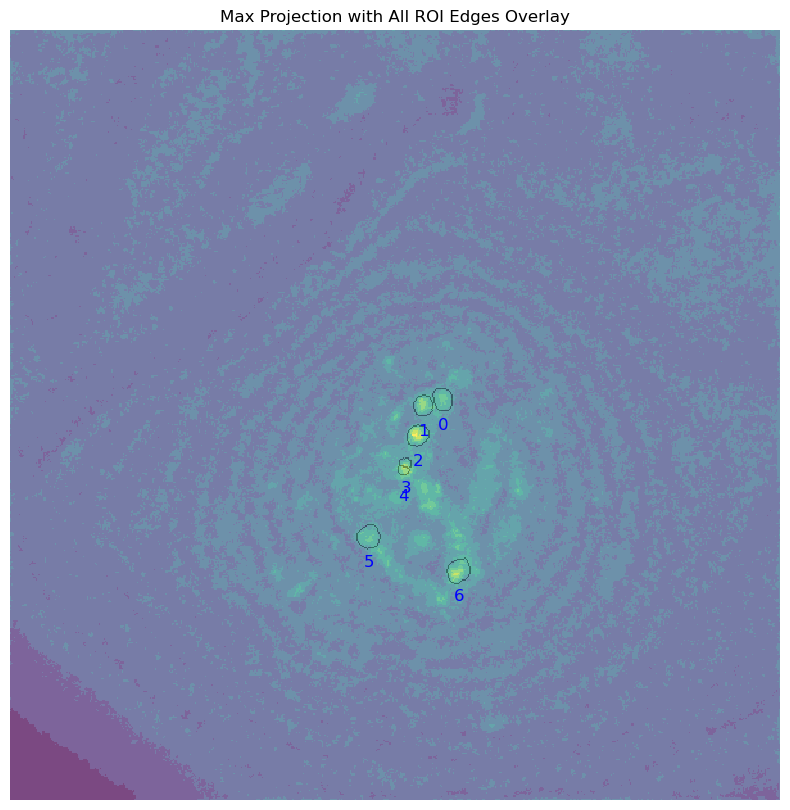

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max21_diff4.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max15_diff5.0.nc


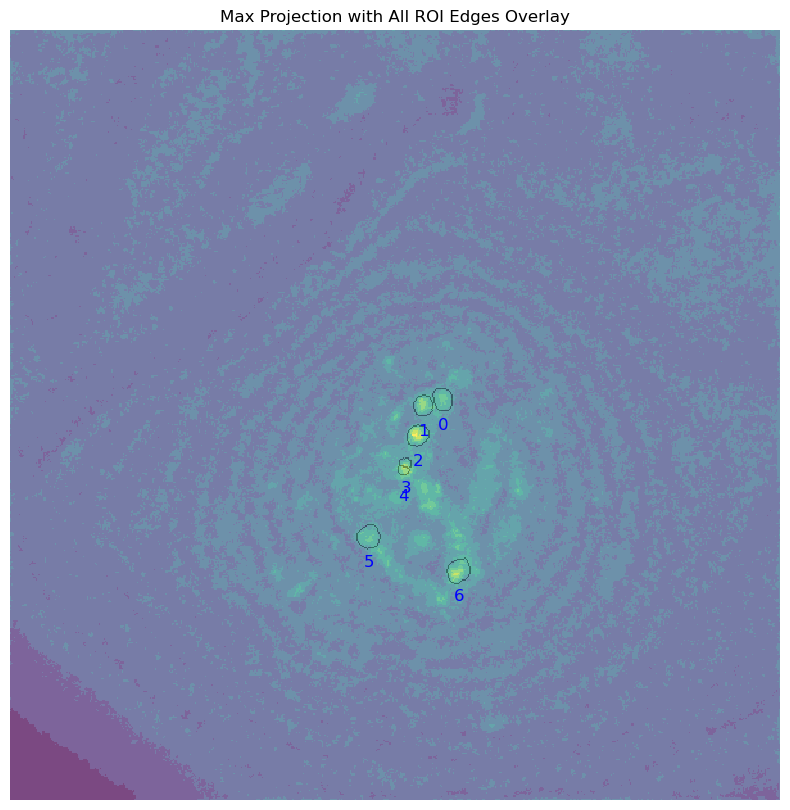

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max15_diff5.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd1500_stp700_max15_diff4.0_pnrauto.nc


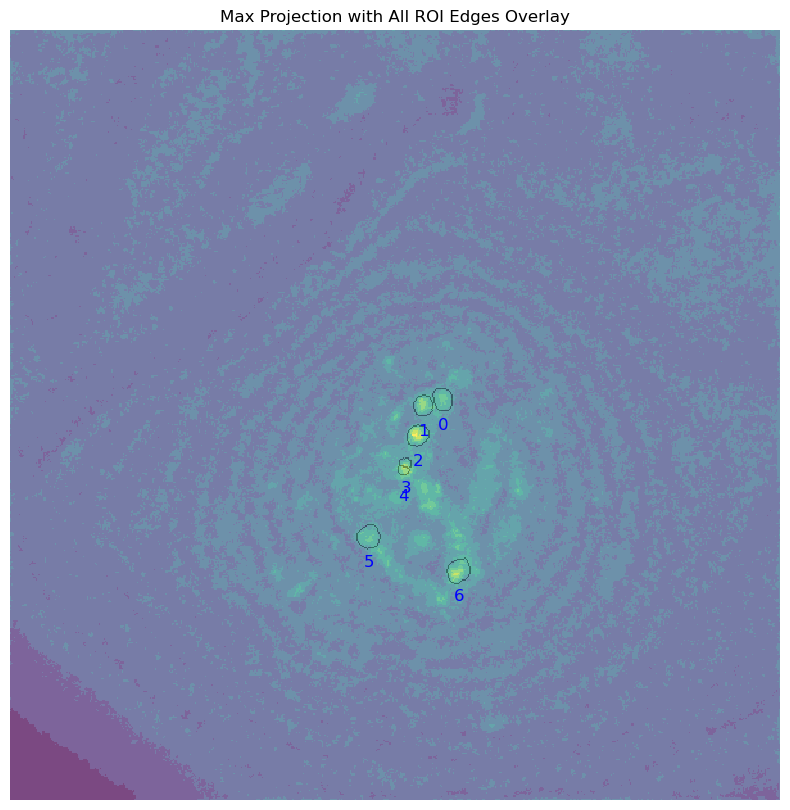

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd1500_stp700_max15_diff4.0_pnrauto.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max25_diff5.0.nc


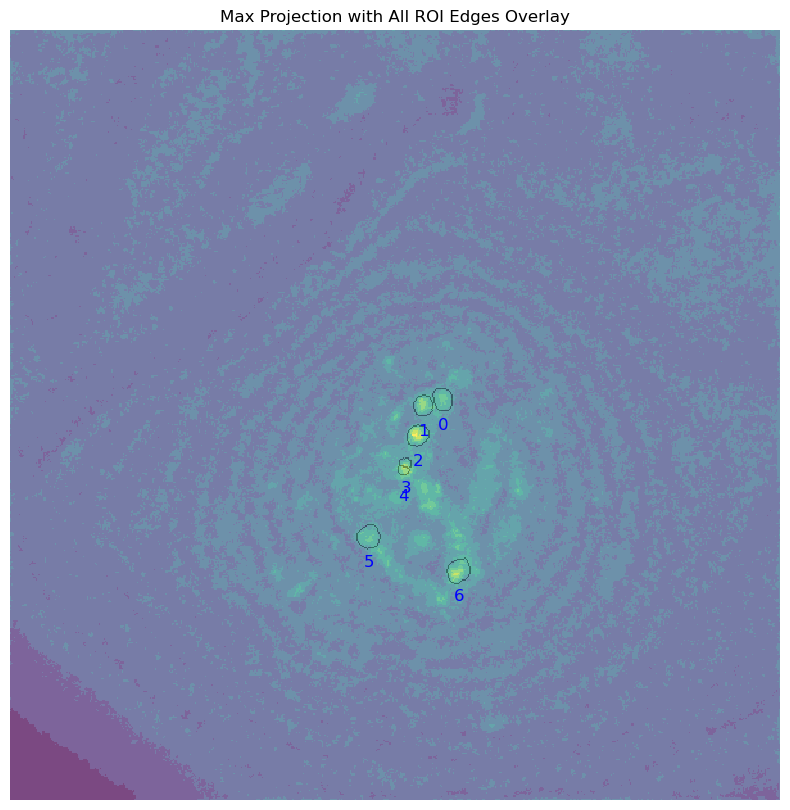

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max25_diff5.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max21_diff5.0.nc


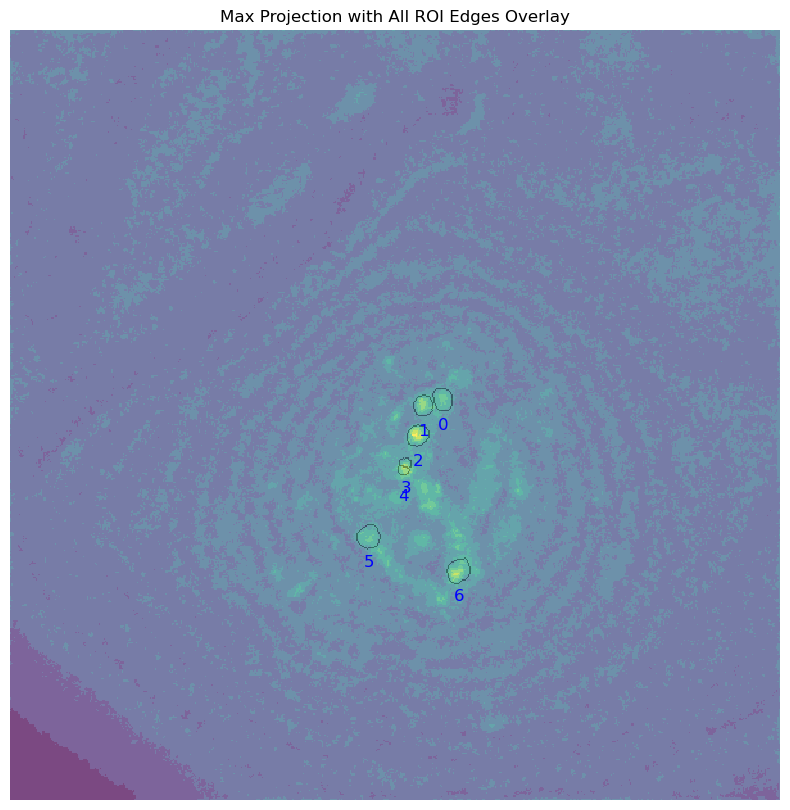

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max21_diff5.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff4.0.nc


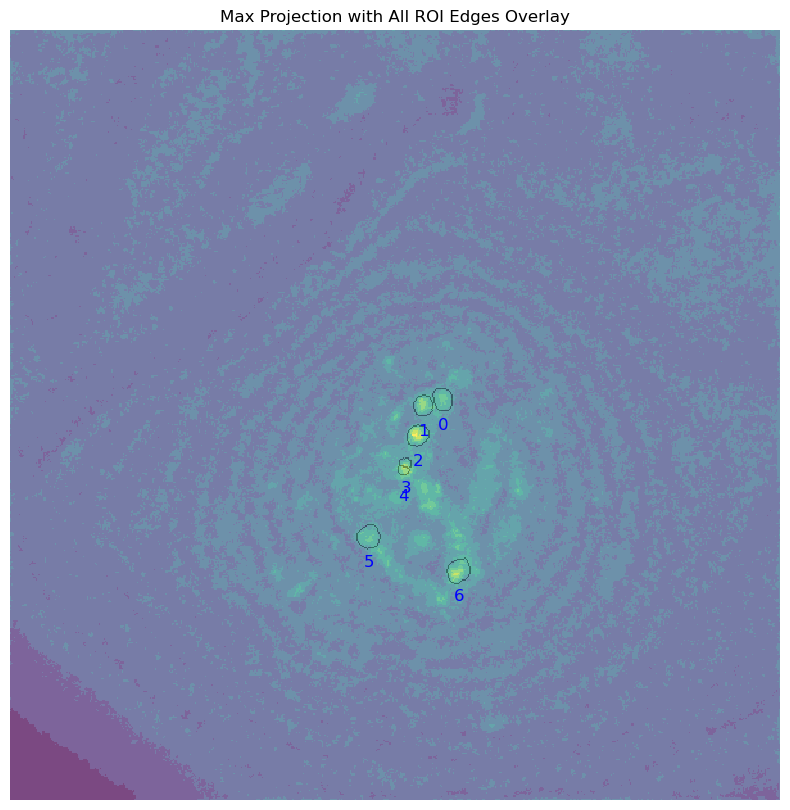

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp700_max15_diff4.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max25_diff3.5.nc


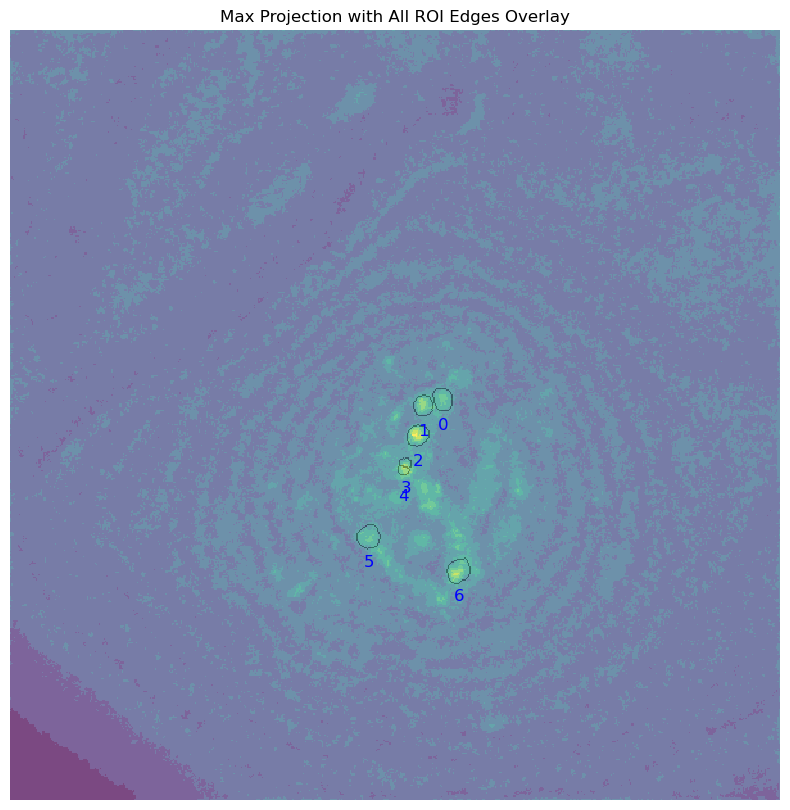

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max25_diff3.5.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff3.5.nc


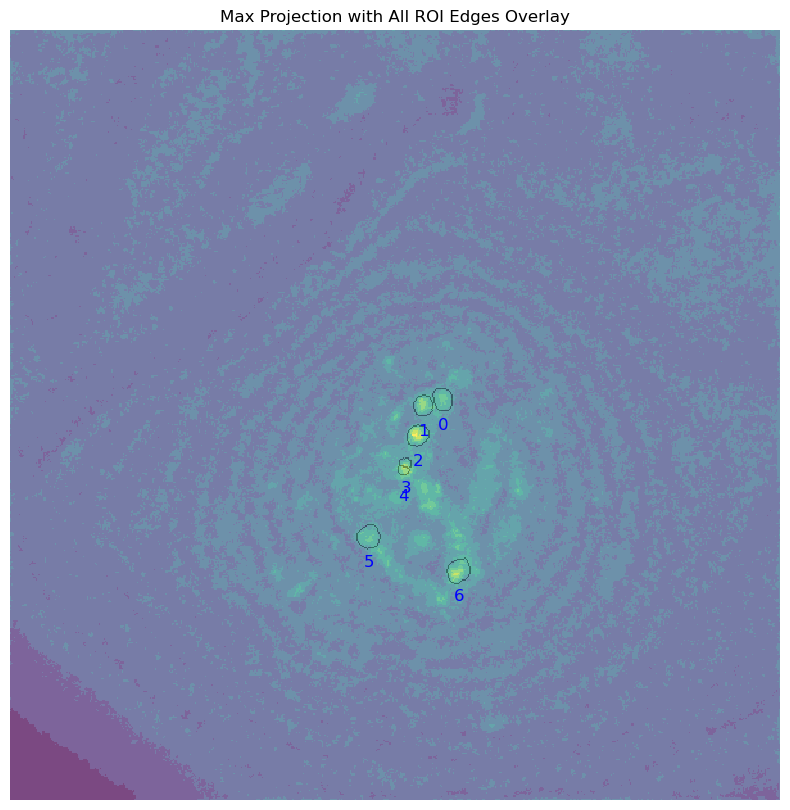

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp700_max15_diff3.5.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max15_diff3.5.nc


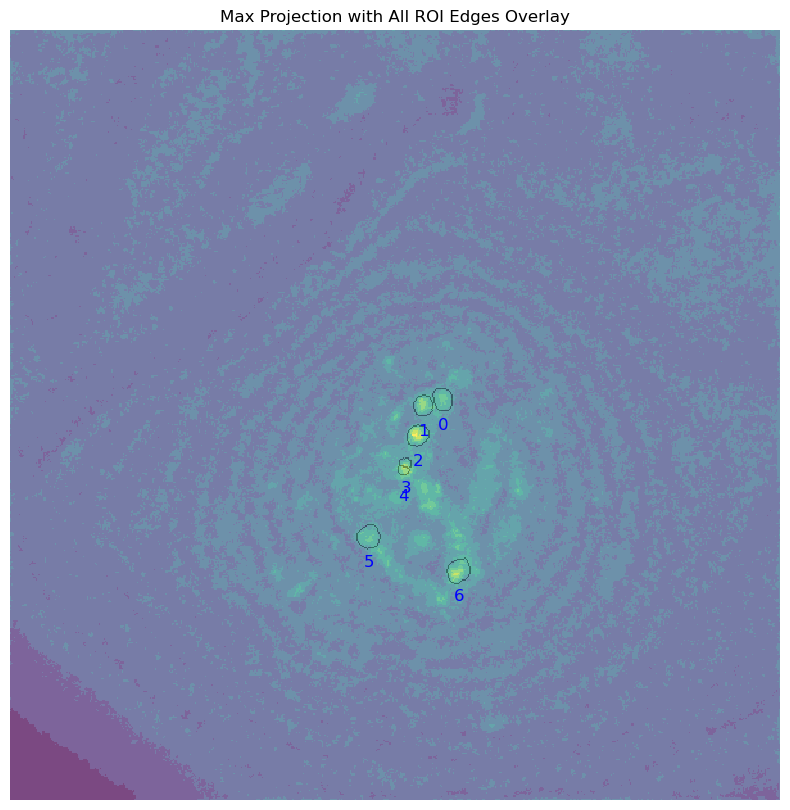

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max15_diff3.5.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max18_diff5.0.nc


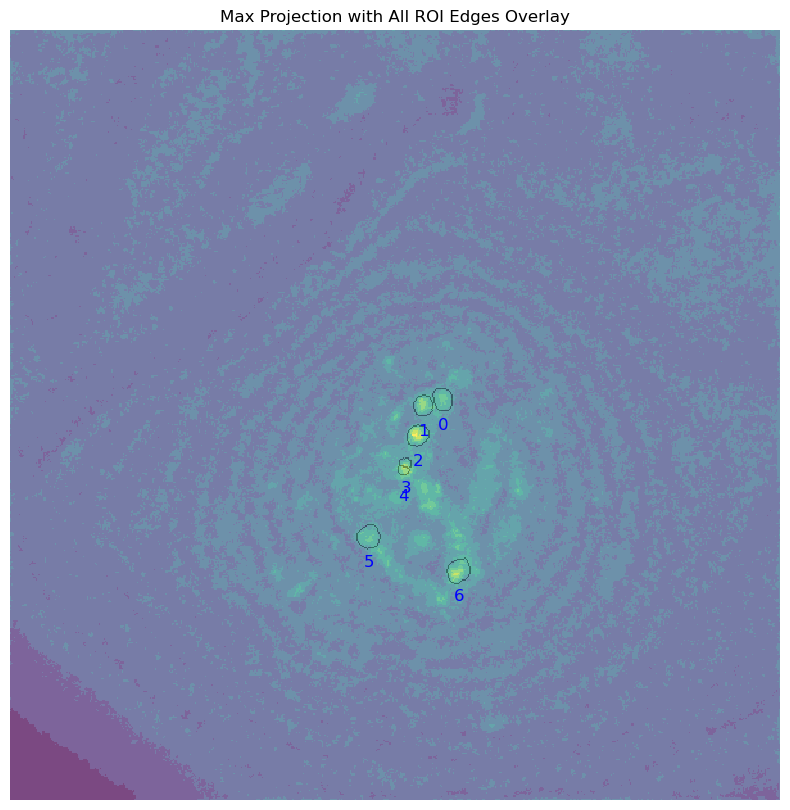

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max18_diff5.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max21_diff3.5.nc


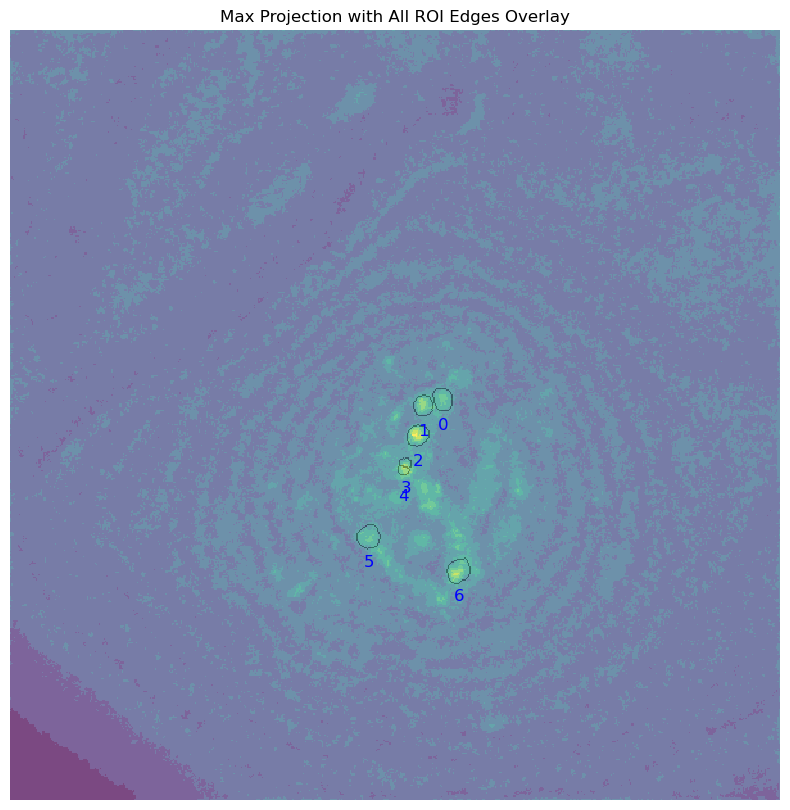

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max21_diff3.5.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff3.5_pnrauto.nc


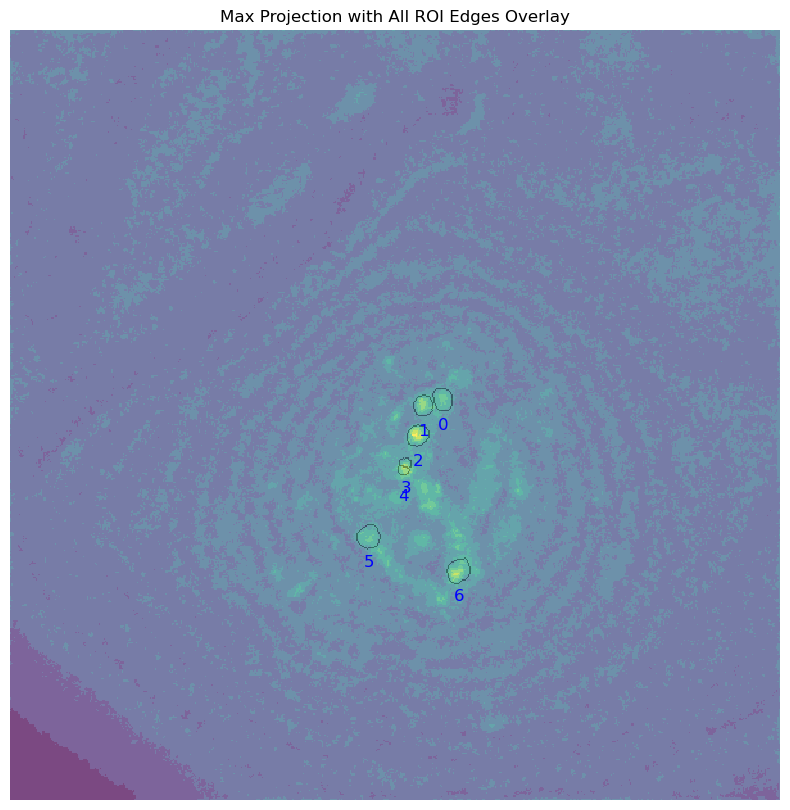

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp700_max15_diff3.5_pnrauto.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff5.0_pnrauto.nc


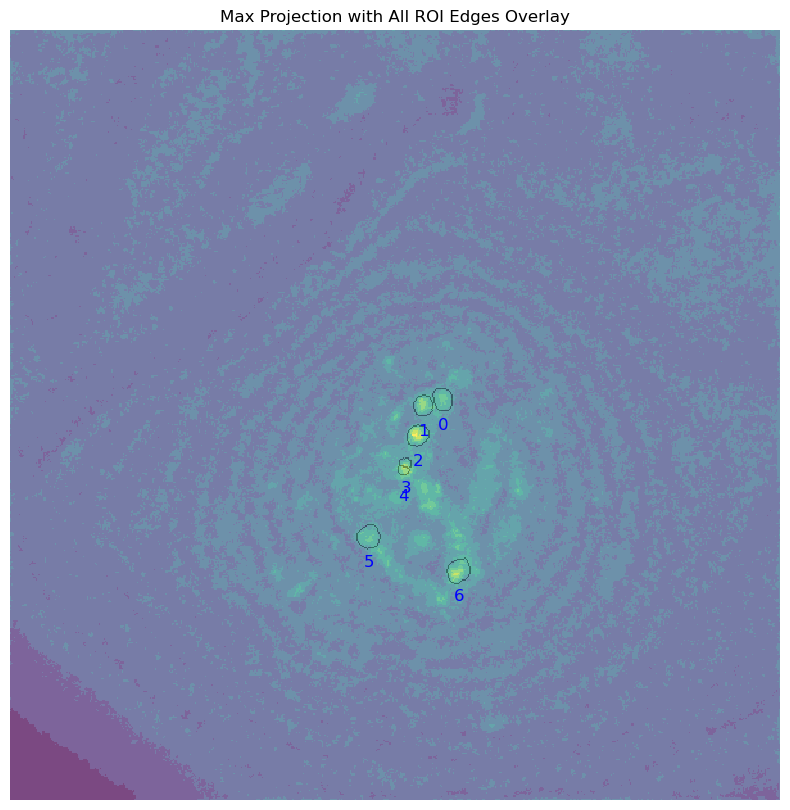

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp700_max15_diff5.0_pnrauto.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max18_diff5.0.nc


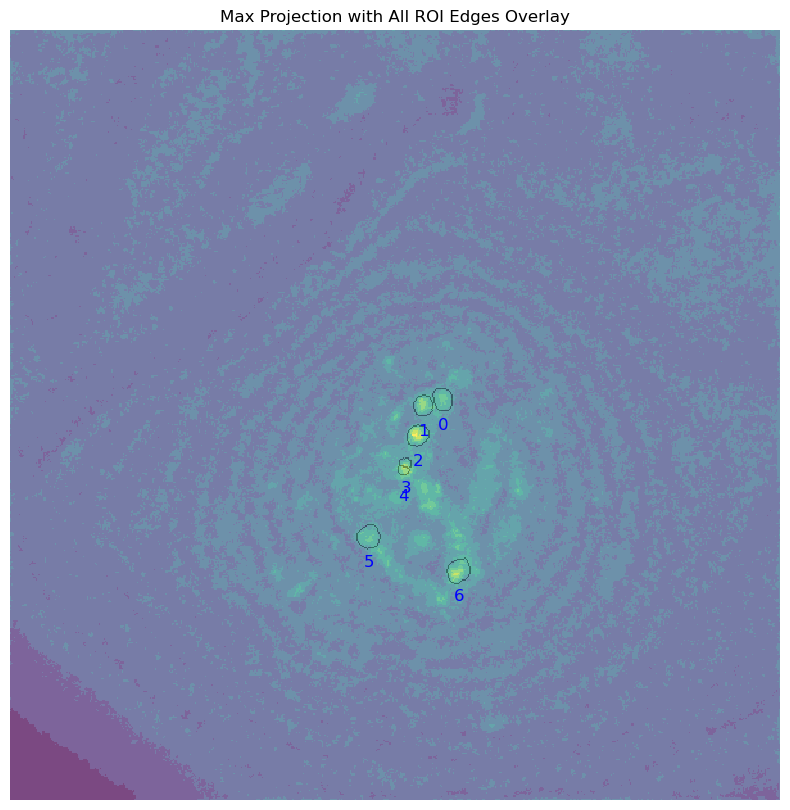

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max18_diff5.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max18_diff4.0.nc


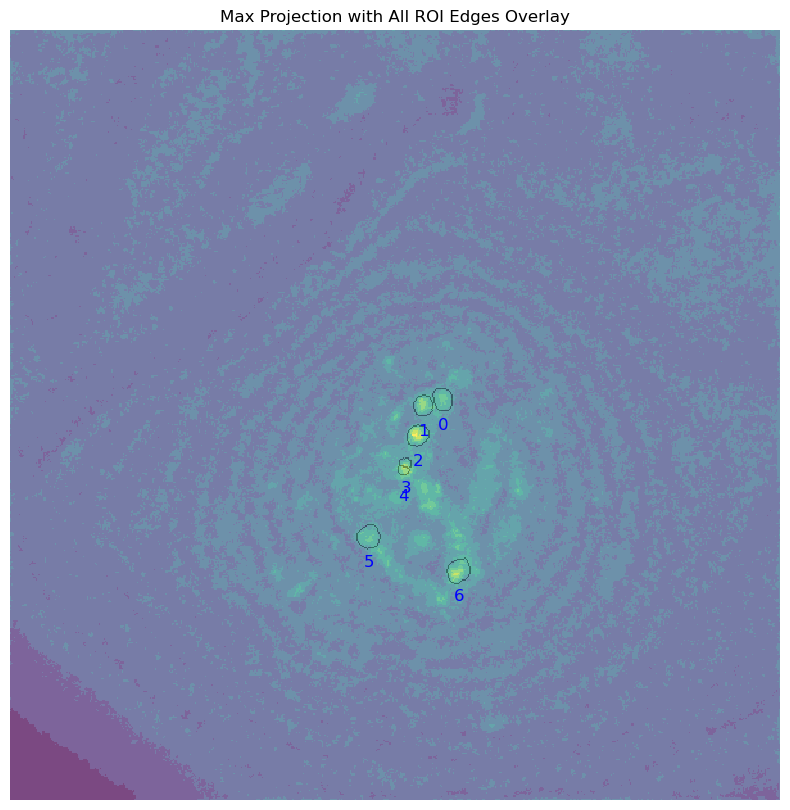

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max18_diff4.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max21_diff4.0.nc


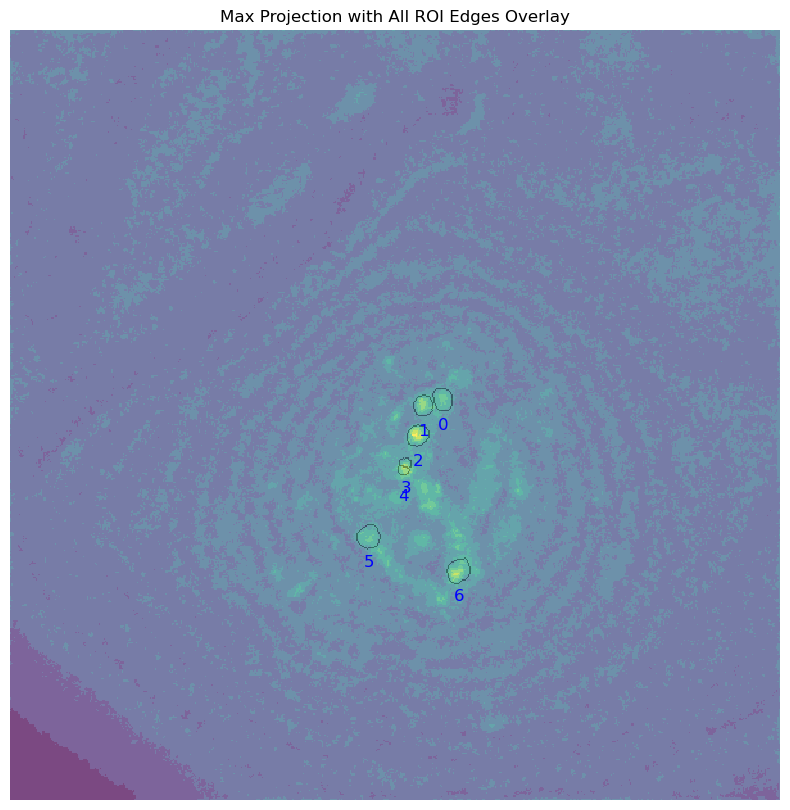

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max21_diff4.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max15_diff4.0.nc


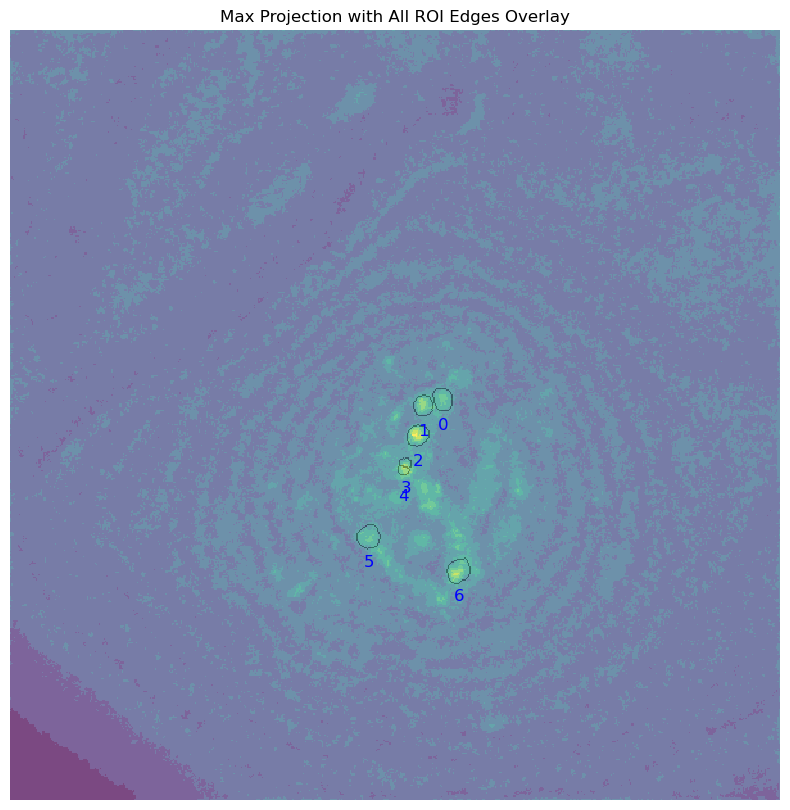

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max15_diff4.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max25_diff4.0.nc


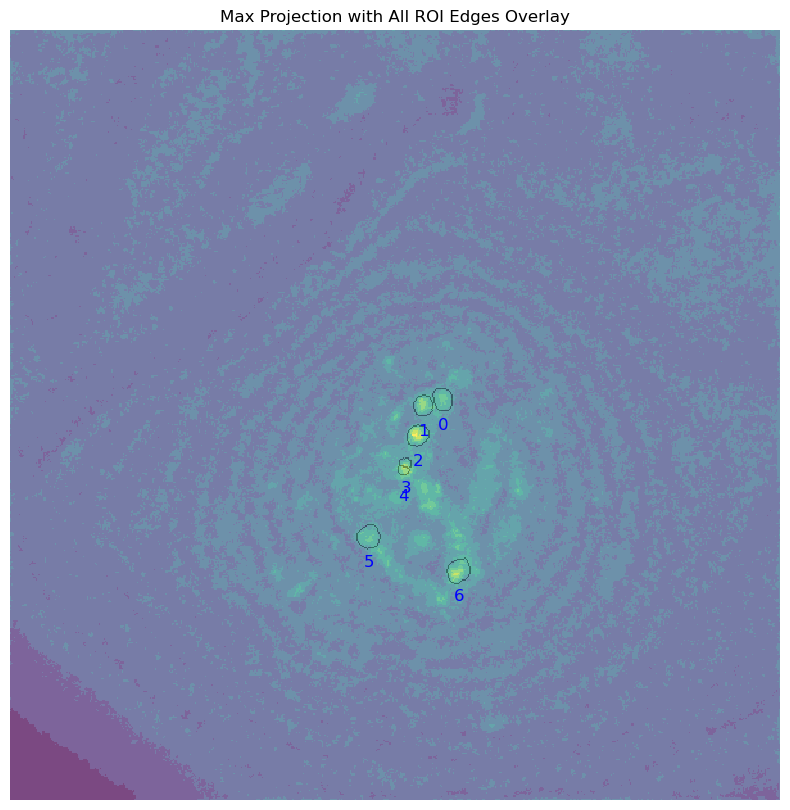

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max25_diff4.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max25_diff3.5.nc


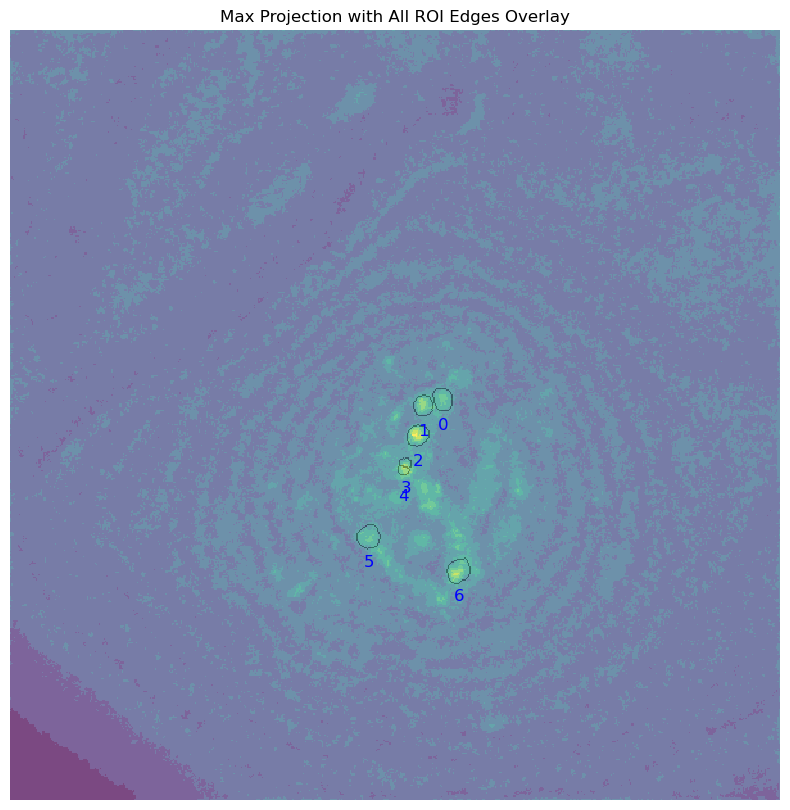

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max25_diff3.5.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max15_diff5.0.nc


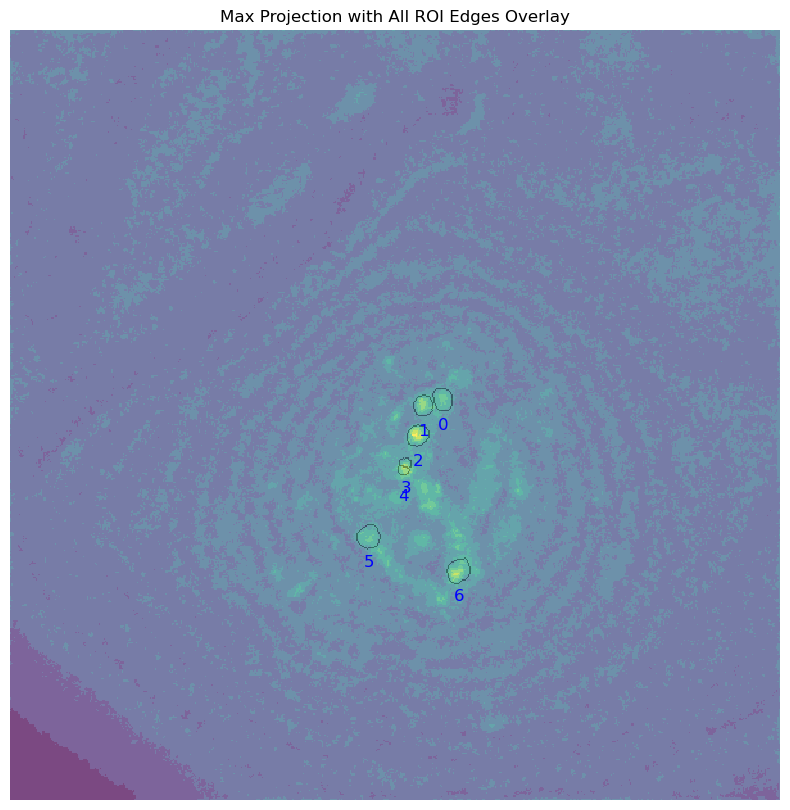

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max15_diff5.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max18_diff3.5.nc


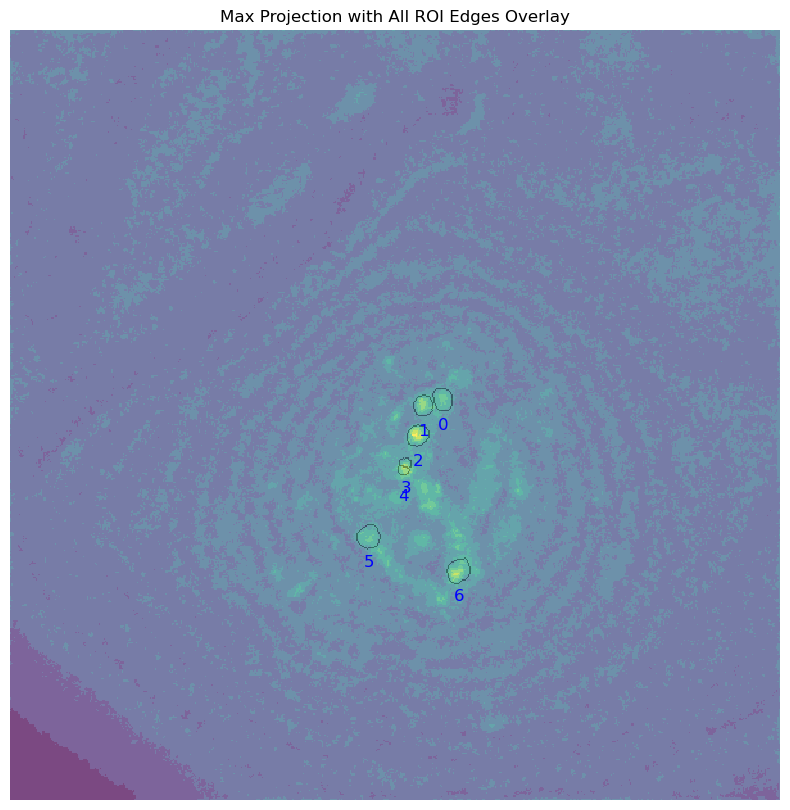

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max18_diff3.5.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max25_diff5.0.nc


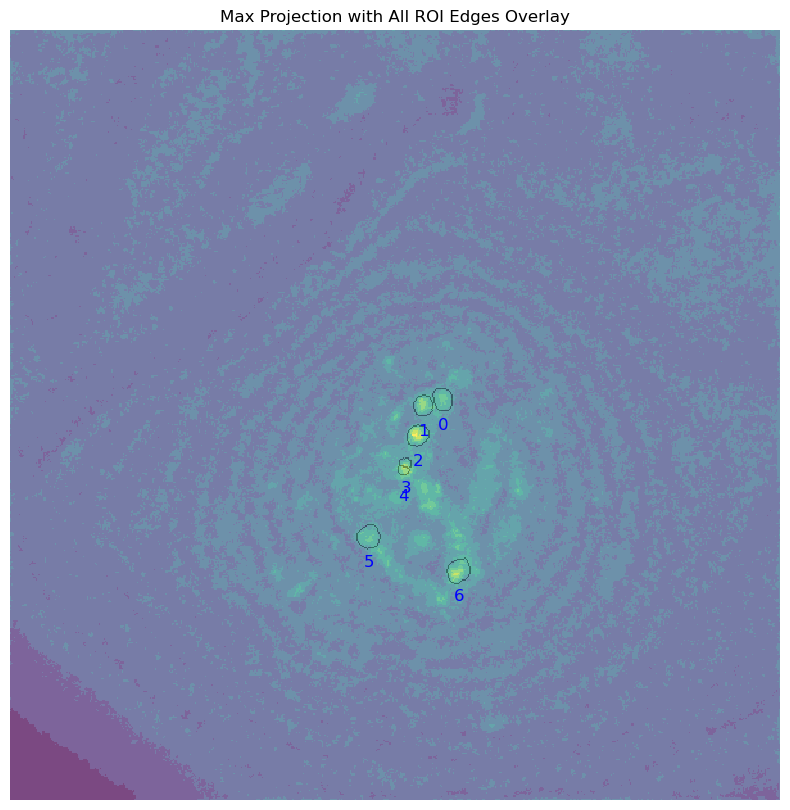

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max25_diff5.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max15_diff4.0.nc


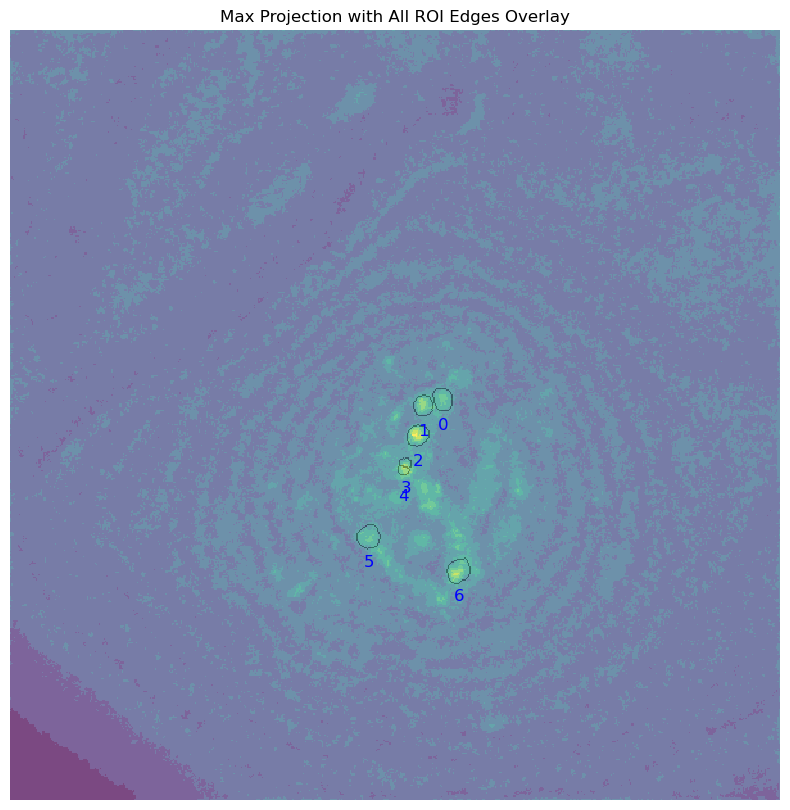

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max15_diff4.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max21_diff5.0.nc


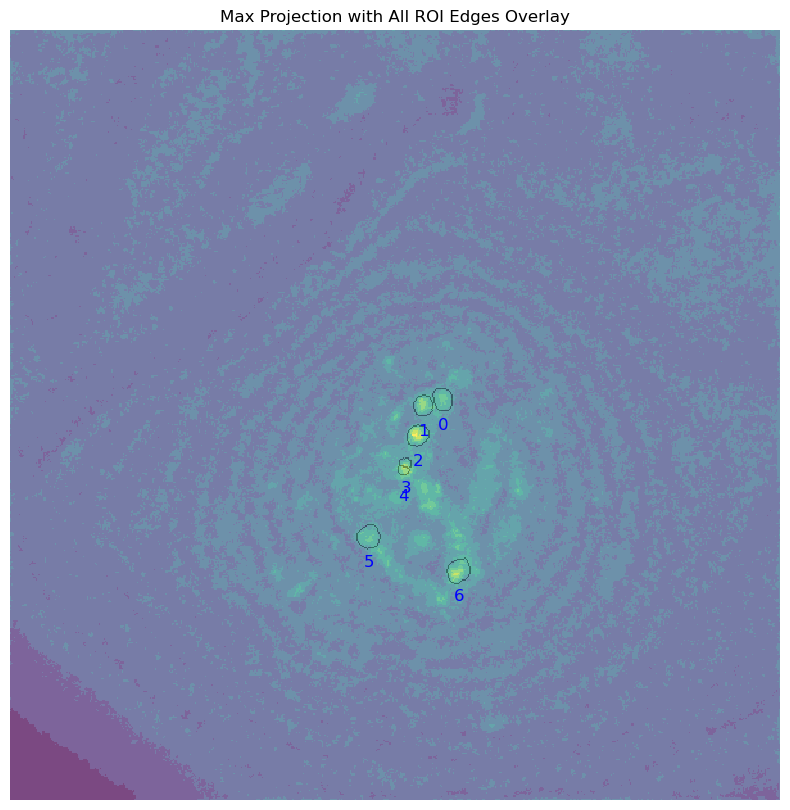

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max21_diff5.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max18_diff3.5.nc


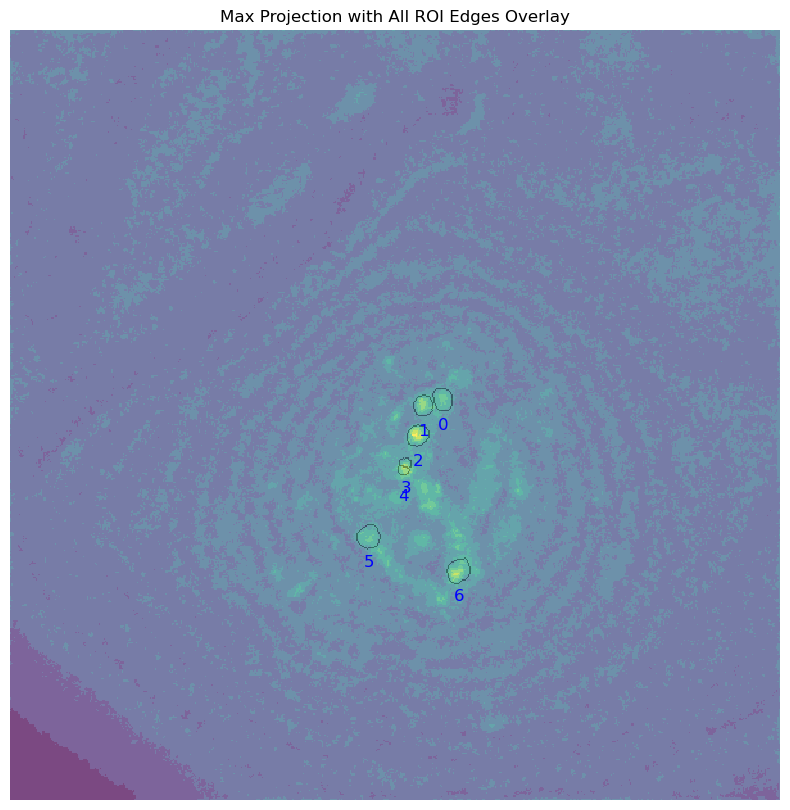

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max18_diff3.5.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max15_diff3.5.nc


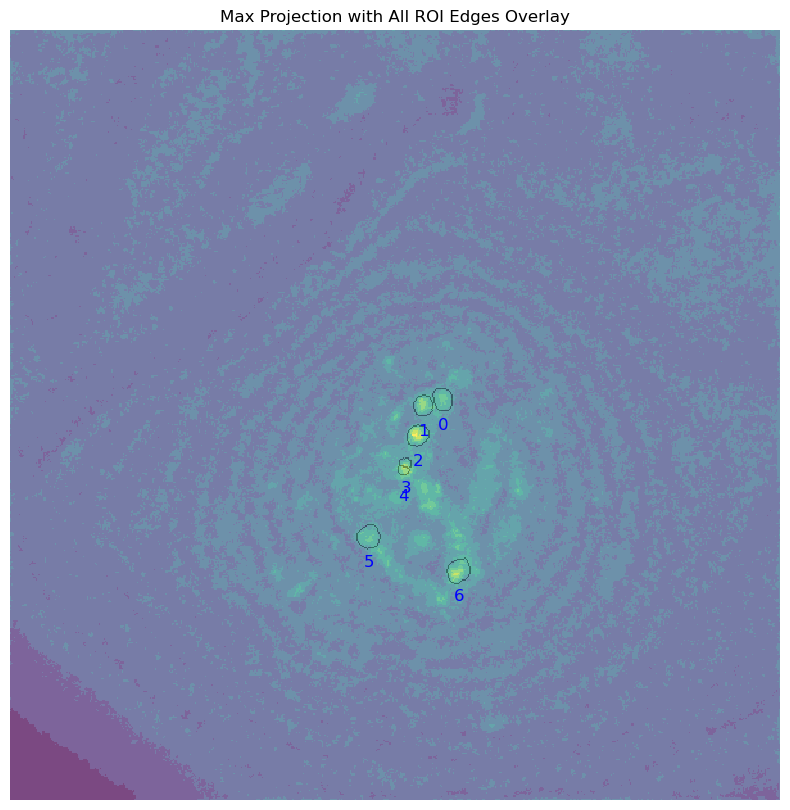

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max15_diff3.5.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max21_diff3.5.nc


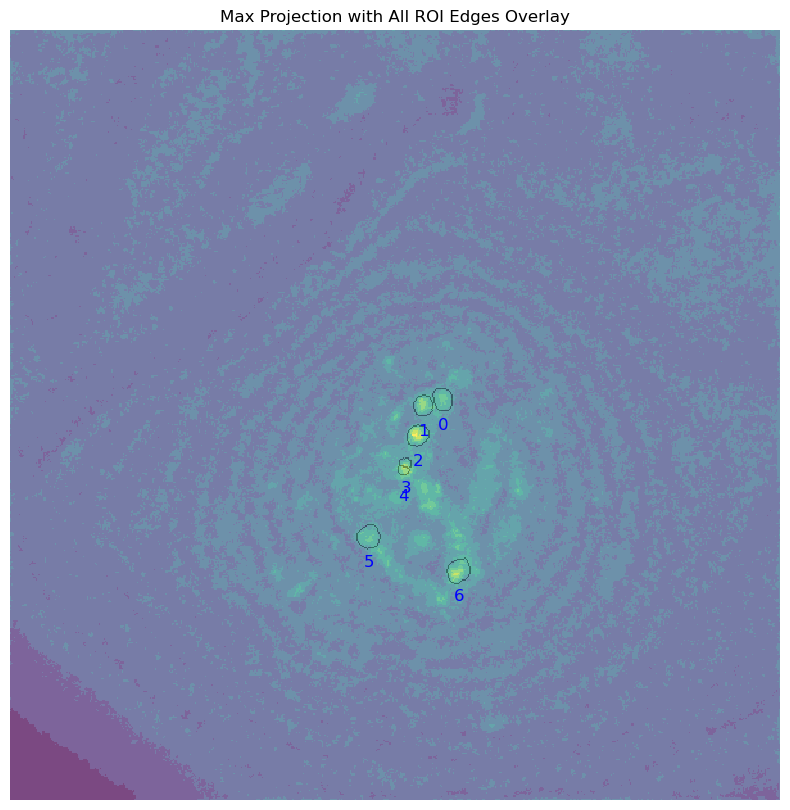

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max21_diff3.5.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max25_diff4.0.nc


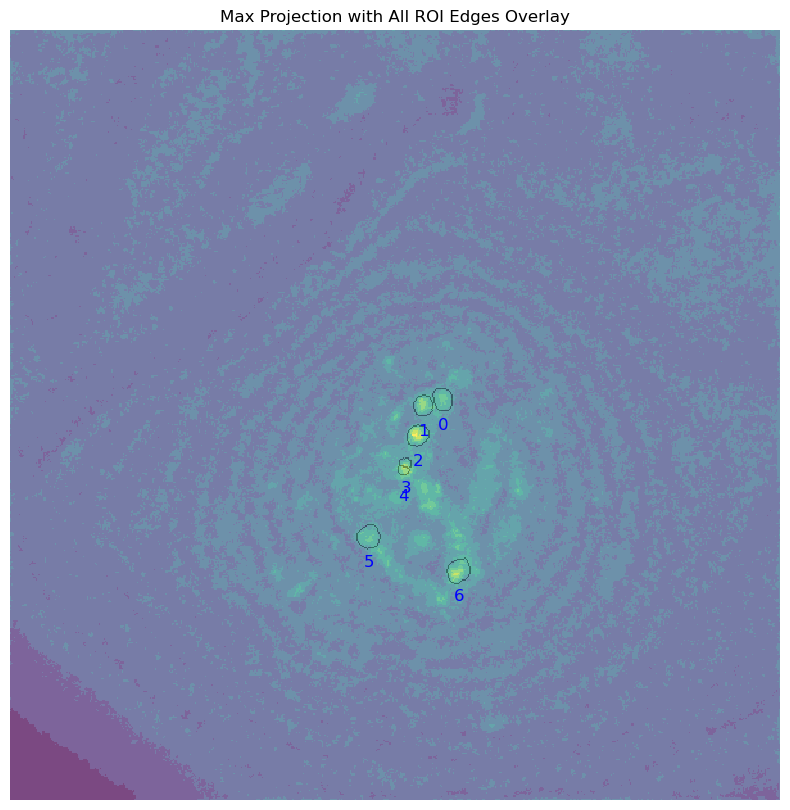

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp500_max25_diff4.0.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd1500_stp700_max15_diff3.5_pnrauto.nc


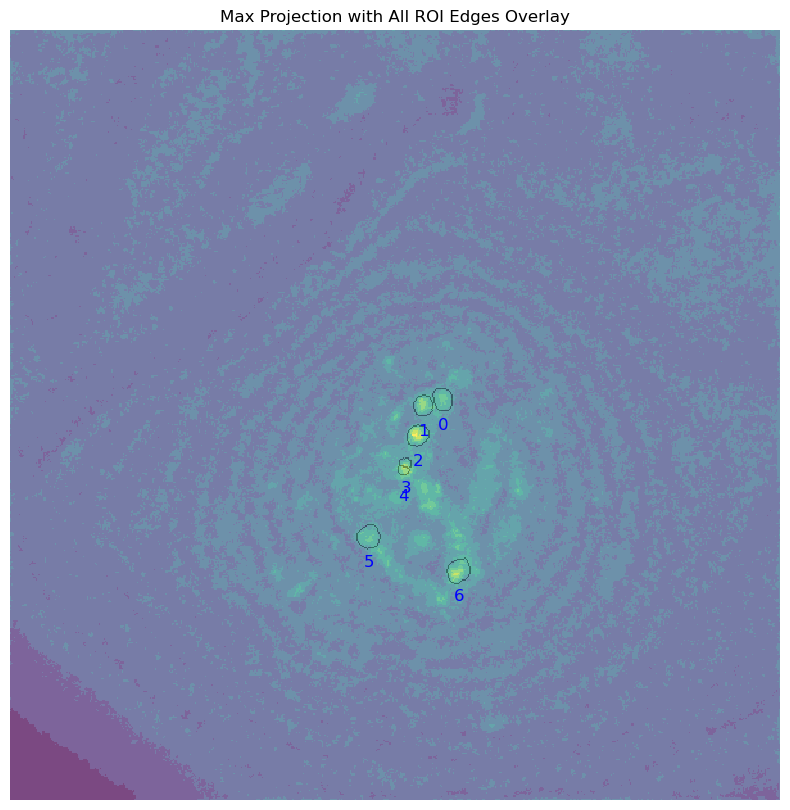

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd1500_stp700_max15_diff3.5_pnrauto.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff4.0_pnrauto.nc


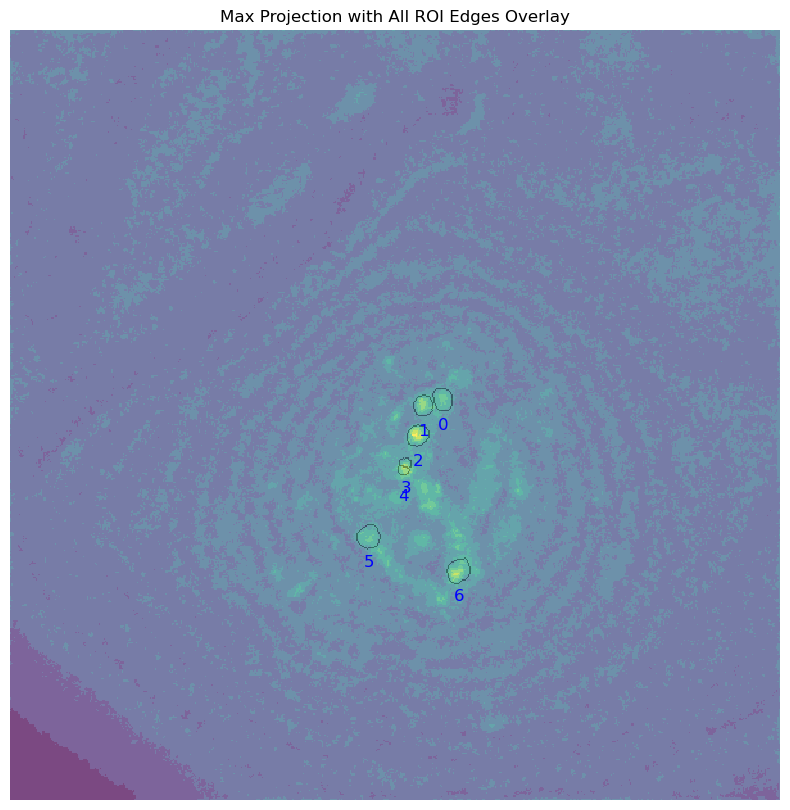

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp700_max15_diff4.0_pnrauto.png
Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max18_diff4.0.nc


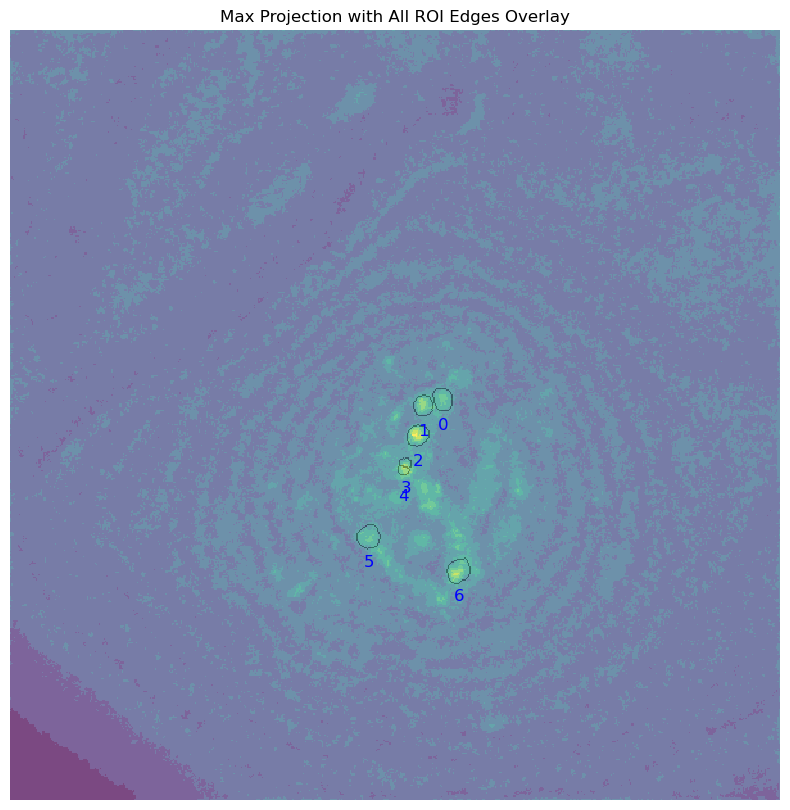

Saved overlay to: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/overlay_wnd700_stp300_max18_diff4.0.png


In [ ]:
import os
import sys
import glob
import shutil
import matplotlib.pyplot as plt

# Ensure the visualization utilities are in the path
sys.path.append(os.path.abspath('../../'))
from utlis.Ca_tools.roi_spike_vis_utlis import load_minian_data, calculate_dff, overlay_all_roi_edges

# --- Session Directory ---
session_dir = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope"

# --- Find All Output Files ---
# Looks for files like "minian_dataset_<unique_id>.nc"
nc_files = glob.glob(os.path.join(session_dir, "minian_dataset_*.nc"))

if not nc_files:
    print("No output files found in the session directory.")
else:
    print(f"Found {len(nc_files)} output files.")

# --- Loop Over Each Output File ---
for nc_file in nc_files:
    print("Processing:", nc_file)
    
    # Copy the specific output file to the expected filename 'minian_dataset.nc'
    temp_nc = os.path.join(session_dir, "minian_dataset.nc")
    shutil.copy2(nc_file, temp_nc)
    
    # Load data using the default mechanism of load_minian_data
    mini_timestamps = os.path.join(session_dir, 'timeStamps.csv')
    data, ts = load_minian_data(session_dir, mini_timestamps)
    
    # Calculate dF/F (if required for downstream visualization)
    # dF_F = calculate_dff(data)
    
    # Extract the maximum projection for visualization
    max_proj = data['max_proj'].values
    
    # Create an overlay of all ROI edges on the maximum projection
    overlay_all_roi_edges(data, max_proj)
    
    # Set a title with the unique identifier extracted from the filename
    combination_id = os.path.basename(nc_file).replace("minian_dataset_", "").replace(".nc", "")
    plt.title("Overlay ROI Edges: " + combination_id)
    
    # Save the figure in the session directory using the unique identifier
    output_fig = os.path.join(session_dir, f"overlay_{combination_id}.png")
    # plt.savefig(output_fig)
    plt.close()
    # print(f"Saved overlay to: {output_fig}")
    
    # Remove the temporary file to avoid interference with the next iteration
    os.remove(temp_nc)


In [ ]:
# import os
# import glob
# import shutil
# import tempfile
# import matplotlib.pyplot as plt
# import sys
# sys.path.append(os.path.abspath('../../'))
# # Import your utility functions (if needed)
# # from my_new_module import load_minian_data_specific, overlay_roi_edges
# from utlis.Ca_tools.roi_spike_vis_utlis import load_minian_data, calculate_dff, overlay_all_roi_edges

# import numpy as np
# from scipy.ndimage import binary_erosion
# import xarray as xr
# import pandas as pd

# def load_minian_data_specific(nc_path, timestamps_path):
#     """
#     Load minian data from a specific NetCDF file path, and load timestamps from a CSV path.
    
#     Parameters
#     ----------
#     nc_path : str
#         Full path to the .nc file to open.
#     timestamps_path : str
#         Path to the CSV file containing the time stamps.
    
#     Returns
#     -------
#     data : xarray.Dataset
#         The loaded dataset from the .nc file.
#     timestamps : np.ndarray
#         The 'Time Stamp (ms)' column from the timestamps CSV as a NumPy array.
#     """
#     if not os.path.isfile(nc_path):
#         raise FileNotFoundError(f"NetCDF file not found: {nc_path}")
#     if not os.path.isfile(timestamps_path):
#         raise FileNotFoundError(f"Timestamps CSV not found: {timestamps_path}")
    
#     # Open the dataset and load it fully into memory
#     data = xr.open_dataset(nc_path)
#     data = data.load()
    
#     # Load timestamps from CSV
#     timestamps_df = pd.read_csv(timestamps_path)
#     if 'Time Stamp (ms)' not in timestamps_df.columns:
#         raise ValueError("Expected column 'Time Stamp (ms)' in timestamps CSV.")
    
#     return data, timestamps_df['Time Stamp (ms)'].values

# def overlay_all_roi_edges_no_show(data, max_proj):
#     """
#     Overlay edges of all ROIs on the max projection image, without calling plt.show().
#     Returns the figure and axes so you can save or display as needed.
    
#     Parameters
#     ----------
#     data : xarray.Dataset
#         Must contain 'A': either a dense array [n_rois, width*height] or a sparse csc.
#     max_proj : np.ndarray
#         2D array (height, width) representing the max projection image.

#     Returns
#     -------
#     fig : matplotlib.figure.Figure
#     ax : matplotlib.axes._axes.Axes
#         The figure and axes that were created for this overlay.
#     """
#     # 1) Convert 'A' to a dense array if it's sparse.
#     A_var = data['A']
#     if hasattr(A_var, 'values'):
#         A_dense = A_var.values
#     else:
#         from scipy.sparse import csc_matrix
#         A_dense = csc_matrix((A_var.data, A_var.indices, A_var.indptr),
#                              shape=A_var.shape).toarray()
    
#     # 2) Prepare an empty overlay array (same shape as max_proj).
#     overlay_edges = np.zeros_like(max_proj, dtype=np.uint8)
    
#     # 3) For each ROI, extract the mask, find the edge, and add to overlay.
#     n_rois = A_dense.shape[0]
#     for roi in range(n_rois):
#         roi_mask = A_dense[roi].reshape(max_proj.shape) > 0
#         roi_edge = roi_mask ^ binary_erosion(roi_mask)
#         overlay_edges += roi_edge.astype(np.uint8)
    
#     # Clip to avoid intensities > 1
#     overlay_edges = np.clip(overlay_edges, 0, 1)
    
#     # 4) Create a new figure and axes, and plot the max_proj
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(max_proj, interpolation='nearest') #, cmap='gray'
    
#     # 5) Overlay the ROI edges in red with partial transparency
#     ax.imshow(overlay_edges, cmap='Reds', alpha=0.3, interpolation='nearest')
    
#     # 6) Optionally label ROI centroids
#     for roi in range(n_rois):
#         roi_mask = A_dense[roi].reshape(max_proj.shape) > 0
#         coords = np.argwhere(roi_mask)
#         if coords.size > 0:
#             centroid = coords.mean(axis=0)
#             ax.text(
#                 centroid[1], centroid[0] + 20, str(roi),
#                 color='blue', fontsize=12, ha='center', va='center'
#             )
    
#     # 7) Final styling
#     ax.set_title('Max Projection with All ROI Edges Overlay')
#     ax.axis('off')
    
#     # 8) Do not call plt.show(); return the figure and axes
#     return fig, ax

# # Use your real session directory path
# session_dir = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope"
# nc_files = glob.glob(os.path.join(session_dir, "minian_dataset_*.nc"))

# if not nc_files:
#     print("No output files found in the session directory.")
# else:
#     print(f"Found {len(nc_files)} output files:")
#     for f in nc_files:
#         print(f)

# mini_timestamps = os.path.join(session_dir, 'timeStamps.csv')

# for nc_file in nc_files:
#     print("Processing:", nc_file)
    
#     # Copy each file to a temporary file in the system temporary directory
#     temp_nc = os.path.join(tempfile.gettempdir(), os.path.basename(nc_file))
#     shutil.copy2(nc_file, temp_nc)
    
#     # Load the data (dataset is fully loaded into memory and the file is then closed)
#     data, ts = load_minian_data_specific(temp_nc, mini_timestamps)
    
#     # If you want to calculate dF/F, you could do so here:
#     # dF_F = calculate_dff(data)
    
#     # Extract the max projection
#     max_proj = data['max_proj'].values
    
#     # Create the overlay figure (without displaying it)
#     fig, ax = overlay_all_roi_edges_no_show(data, max_proj)
    
#     # Optionally change the title using the combination ID derived from the filename
#     combination_id = os.path.basename(nc_file).replace("minian_dataset_", "").replace(".nc", "")
#     ax.set_title("Overlay ROI Edges: " + combination_id)
    
#     # Save the figure to an output file in the session directory
#     output_fig = os.path.join(session_dir, f"overlay_{combination_id}.png")
#     fig.savefig(output_fig)
#     plt.close(fig)
#     print(f"Saved overlay to: {output_fig}")
    
#     # Remove the temporary file
#     os.remove(temp_nc)


Found 31 output files:
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max21_diff4.0.nc
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max15_diff5.0.nc
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd1500_stp700_max15_diff4.0_pnrauto.nc
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max25_diff5.0.nc
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max21_diff5.0.nc
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff4.0.nc
/data/bi

Found 31 output files:
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max21_diff4.0.nc
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max15_diff5.0.nc
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd1500_stp700_max15_diff4.0_pnrauto.nc
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max25_diff5.0.nc
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max21_diff5.0.nc
/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff4.0.nc
/data/bi

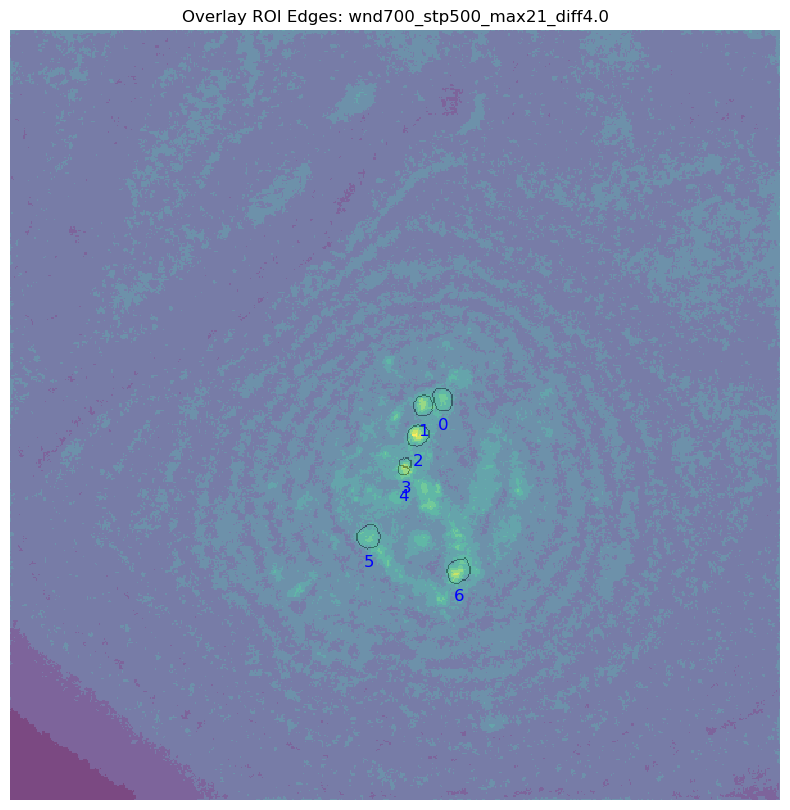

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max15_diff5.0.nc


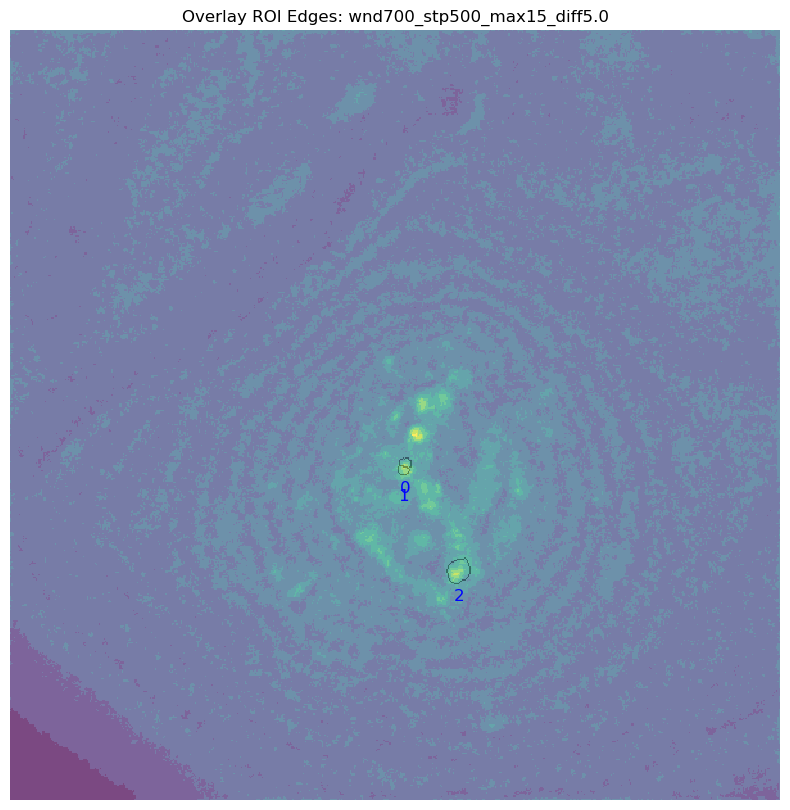

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd1500_stp700_max15_diff4.0_pnrauto.nc


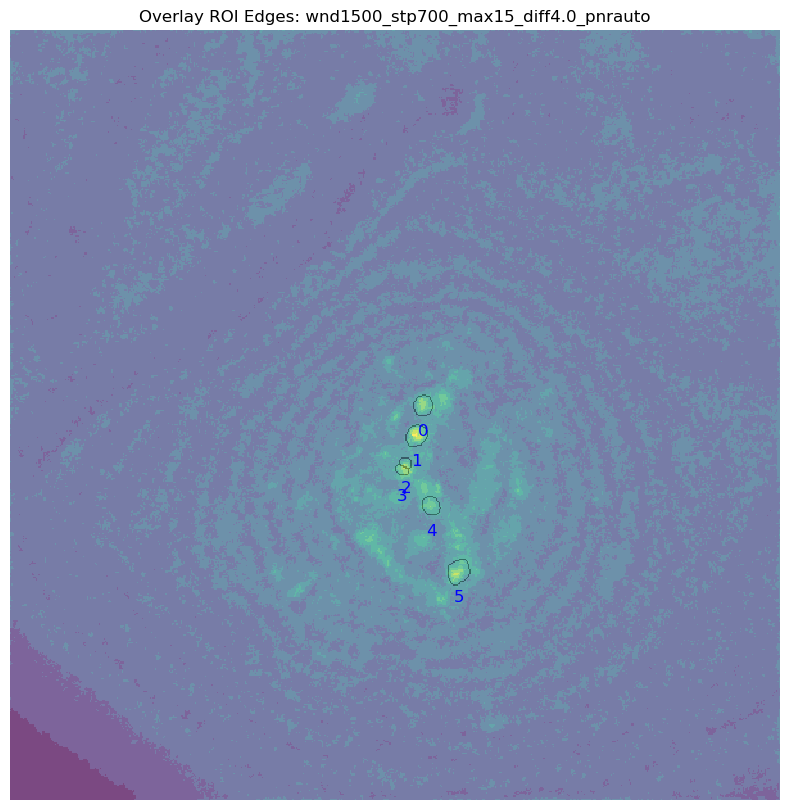

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max25_diff5.0.nc


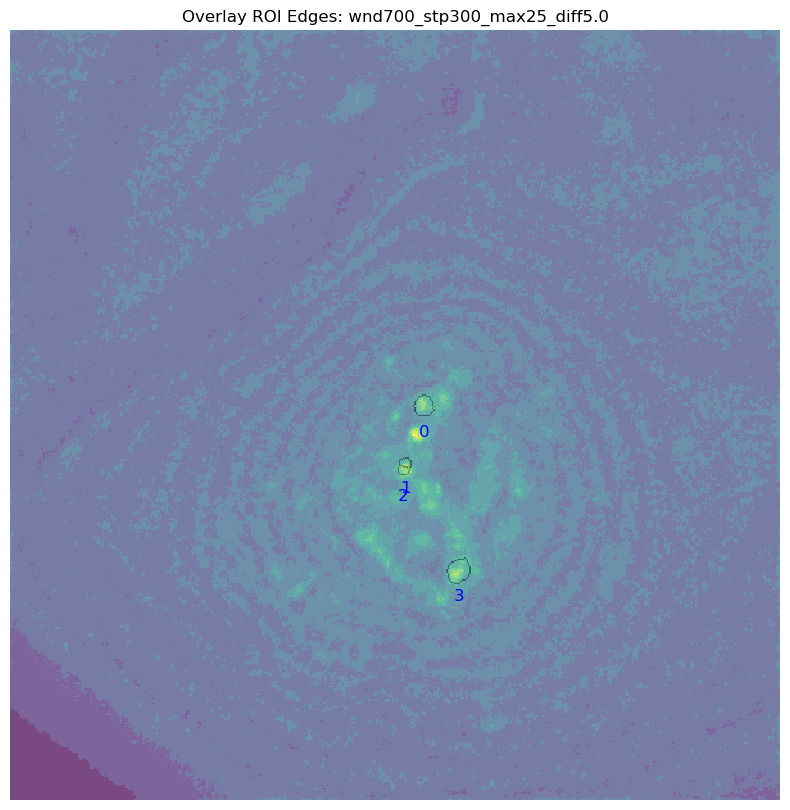

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max21_diff5.0.nc


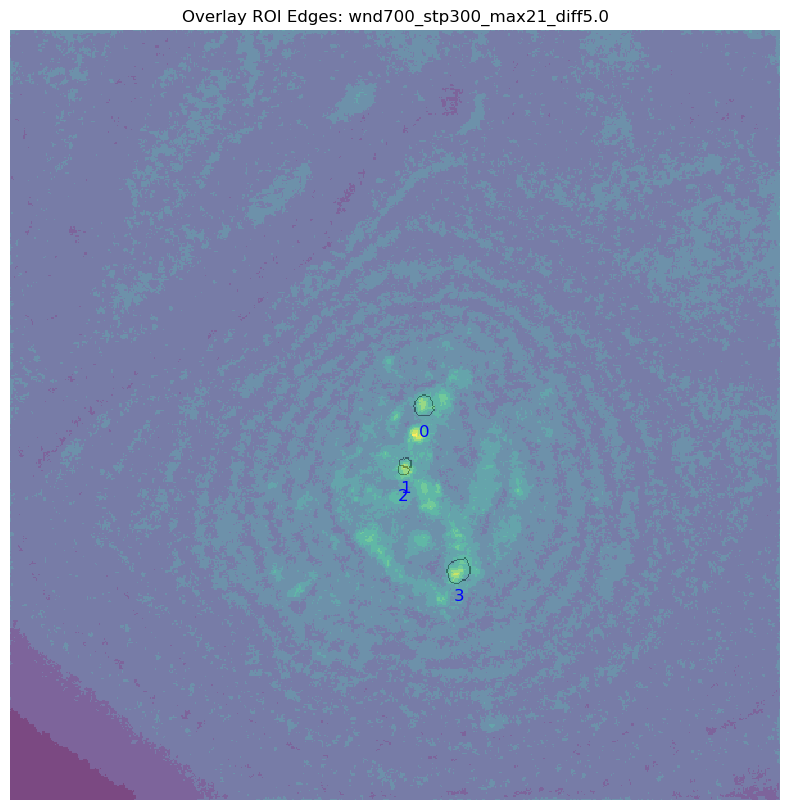

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff4.0.nc


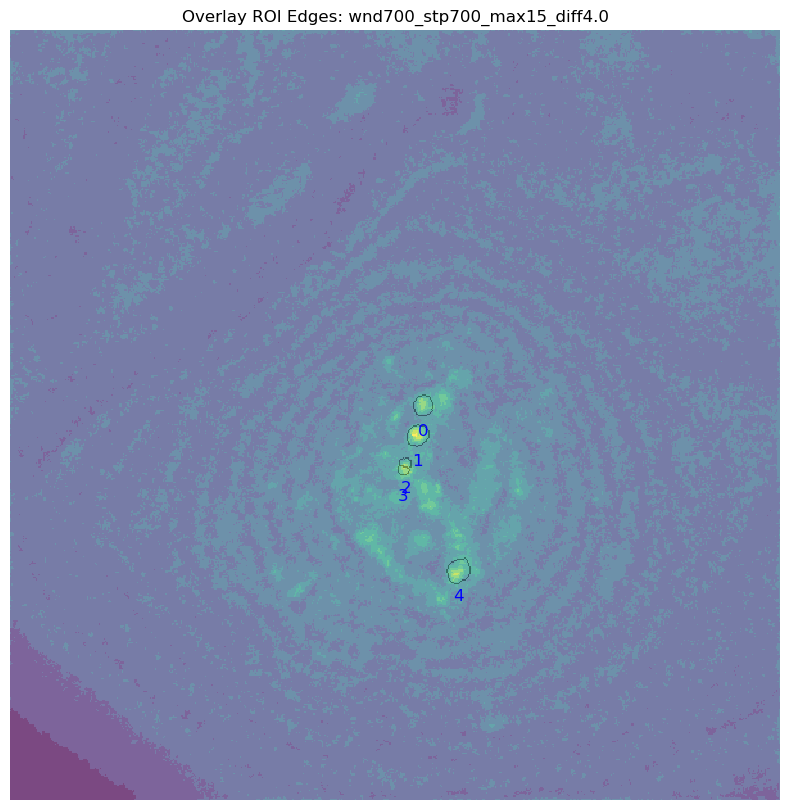

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max25_diff3.5.nc


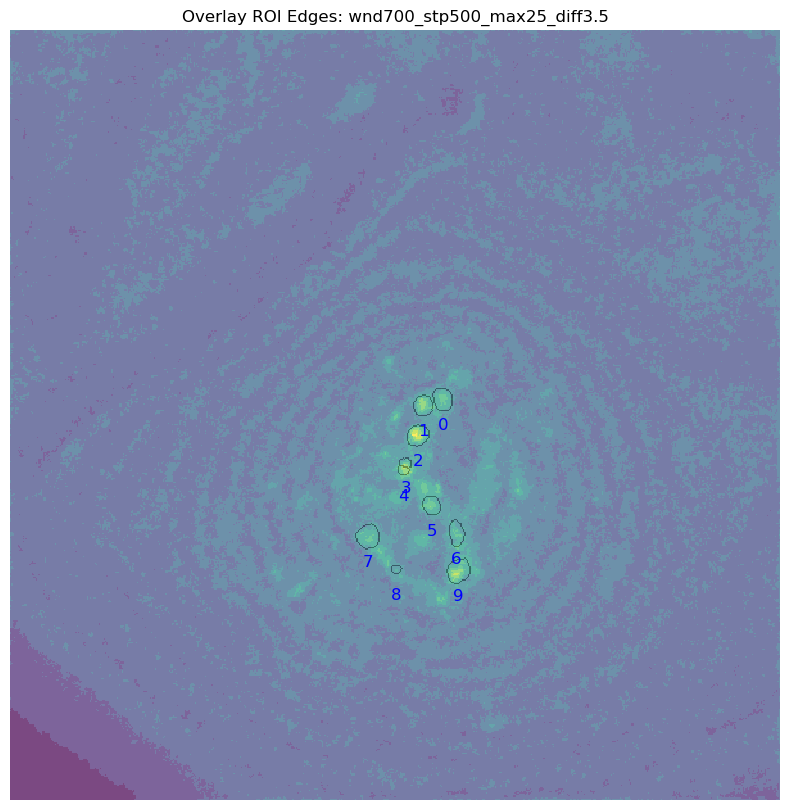

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff3.5.nc


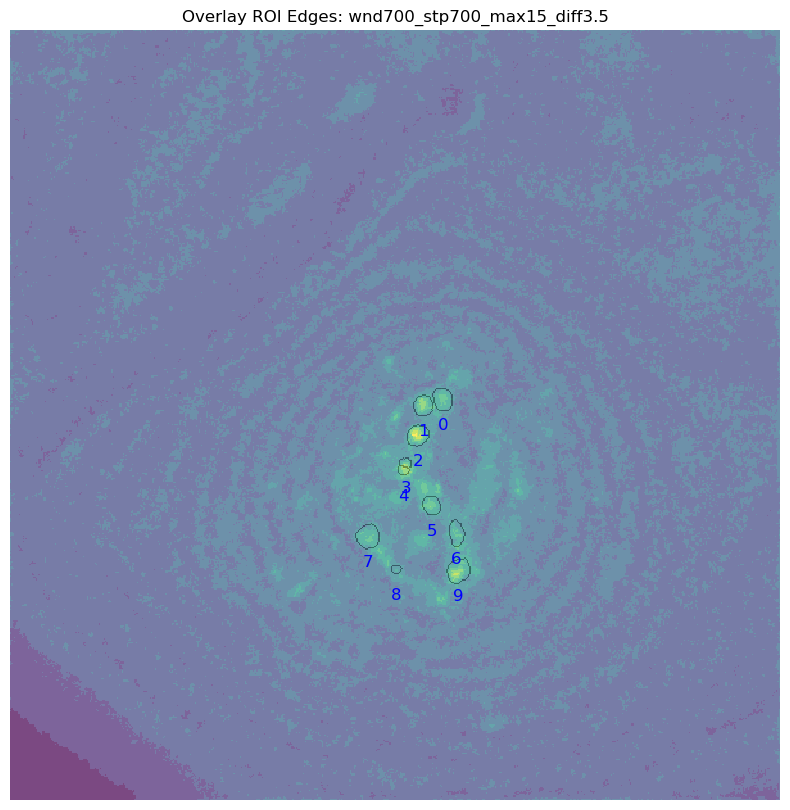

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max15_diff3.5.nc


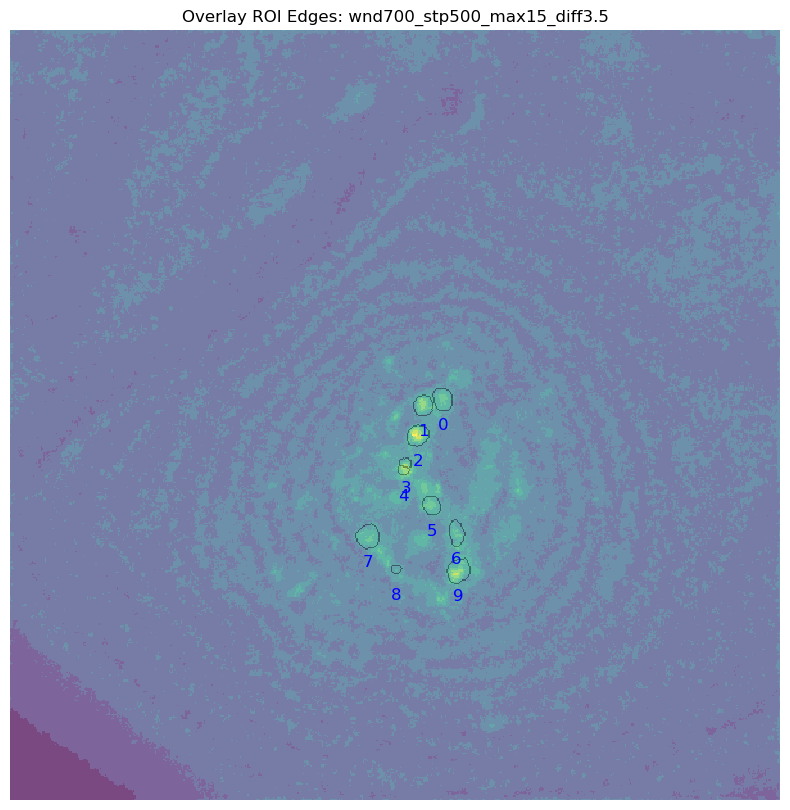

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max18_diff5.0.nc


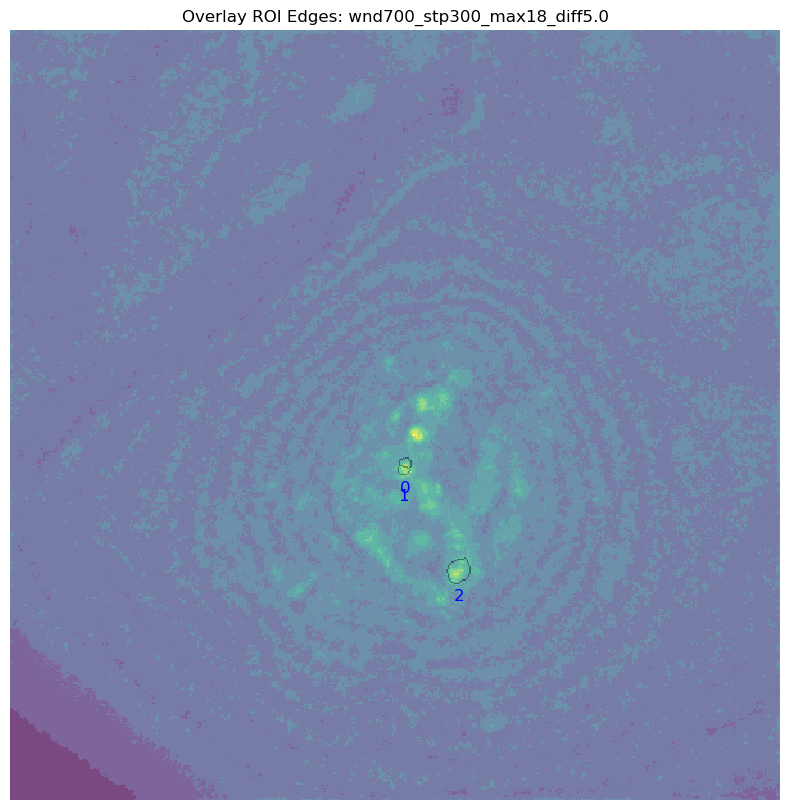

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max21_diff3.5.nc


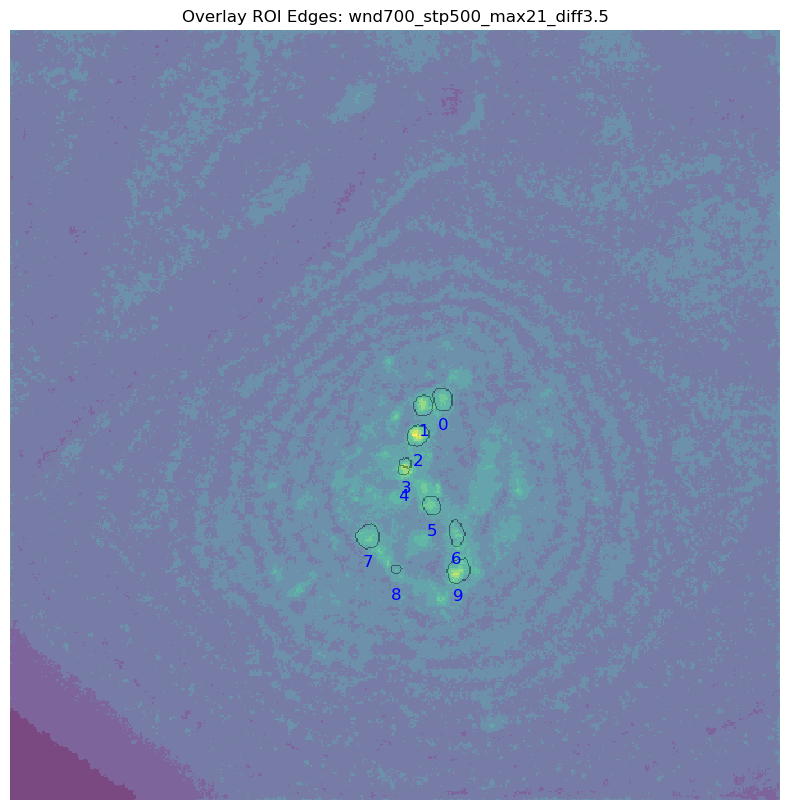

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff3.5_pnrauto.nc


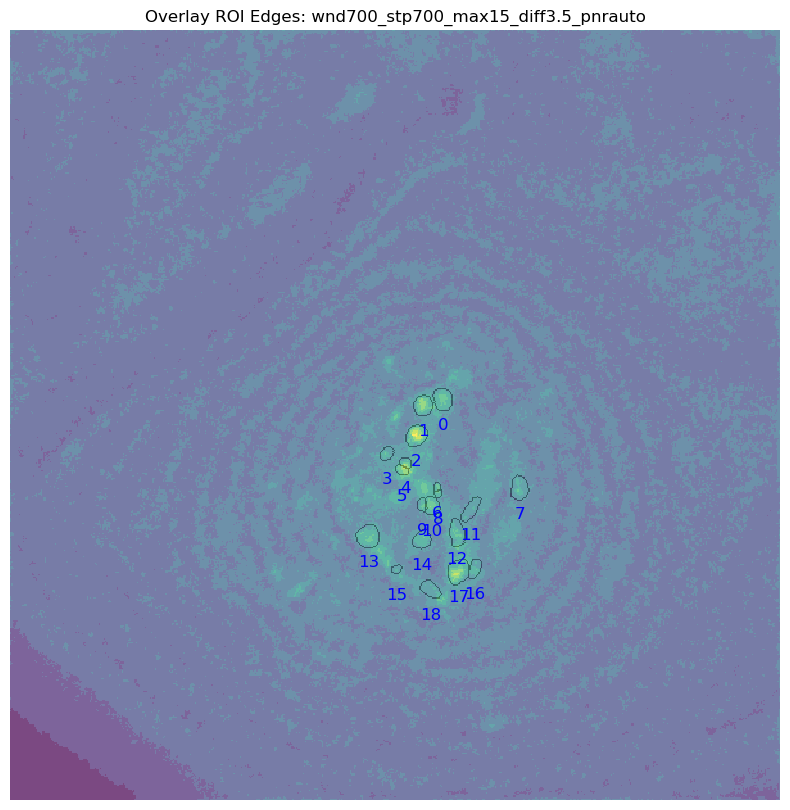

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff5.0_pnrauto.nc


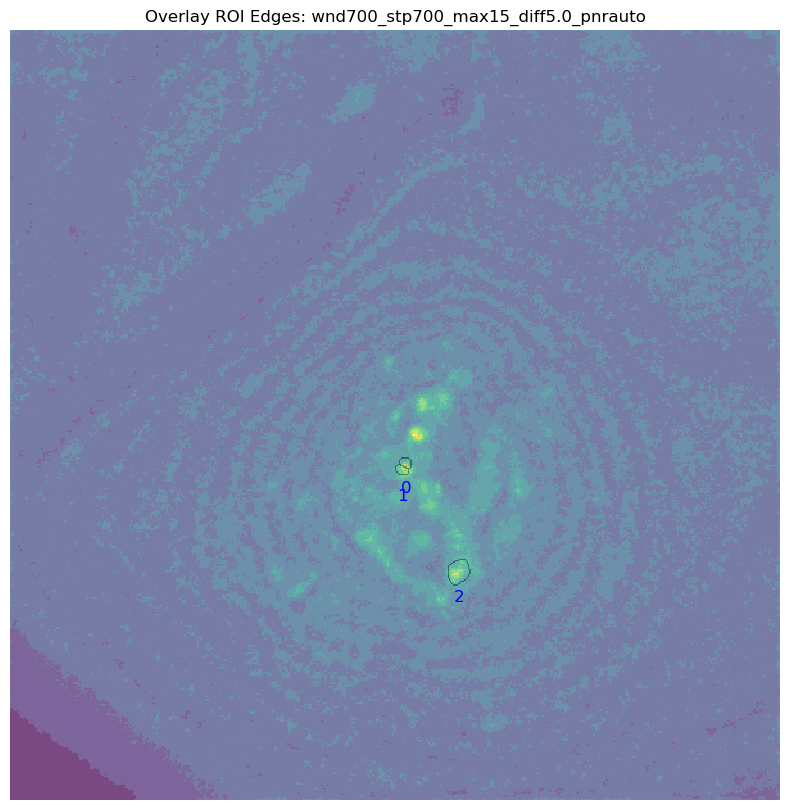

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max18_diff5.0.nc


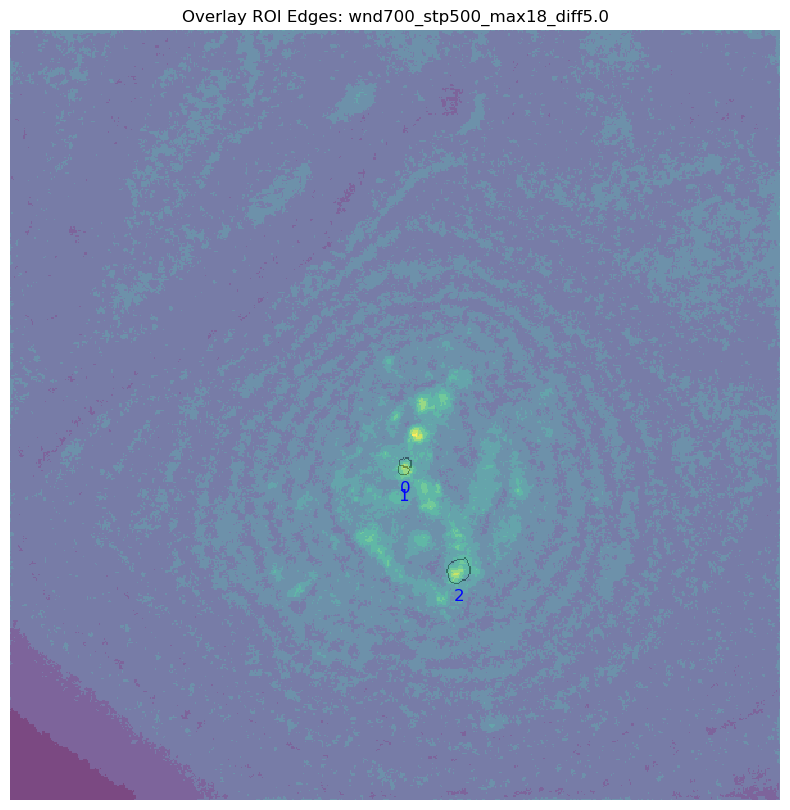

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max18_diff4.0.nc


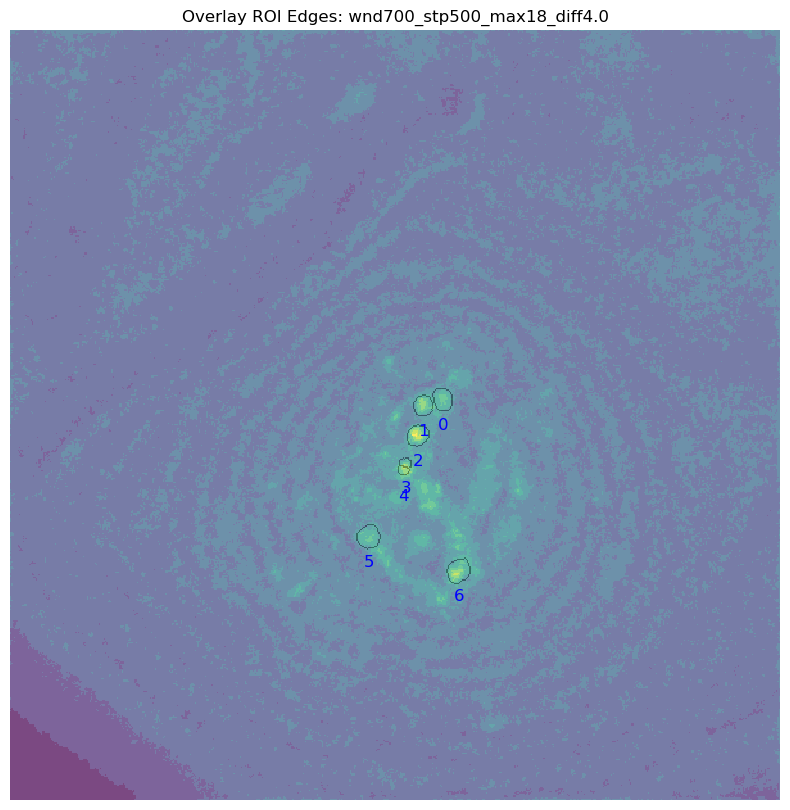

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max21_diff4.0.nc


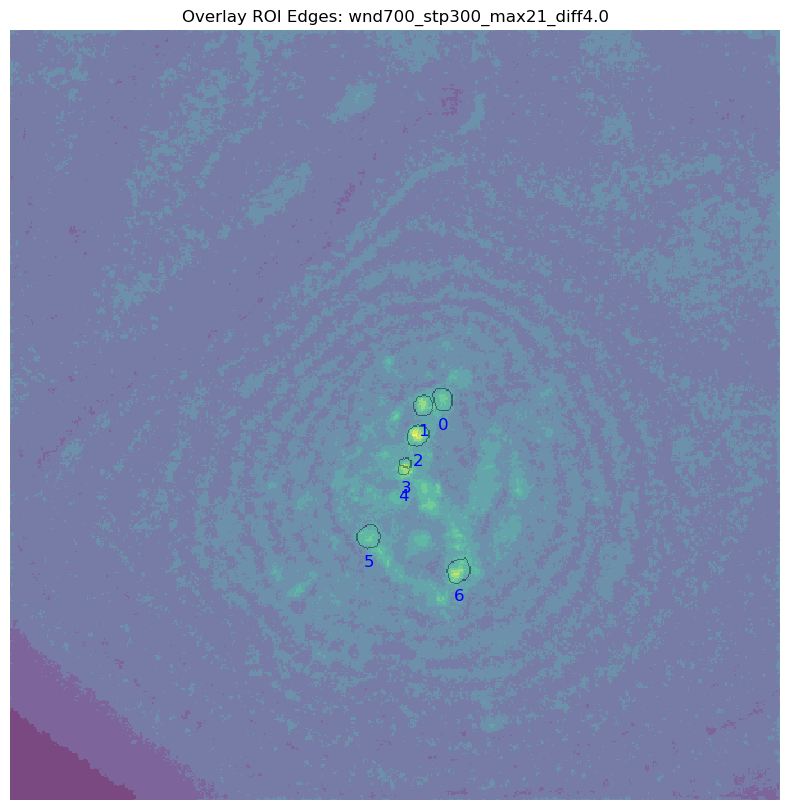

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max15_diff4.0.nc


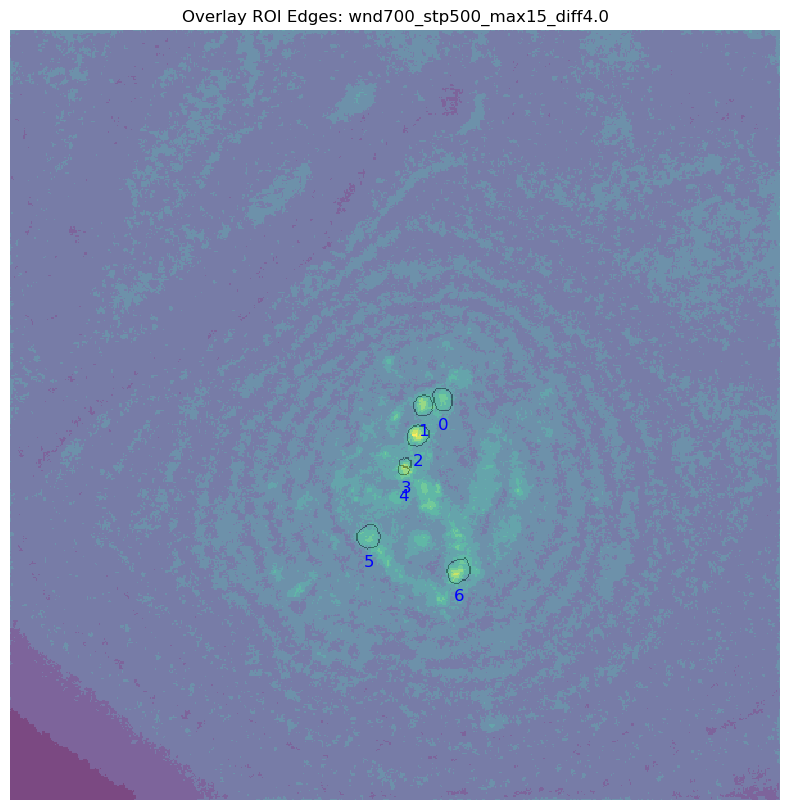

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max25_diff4.0.nc


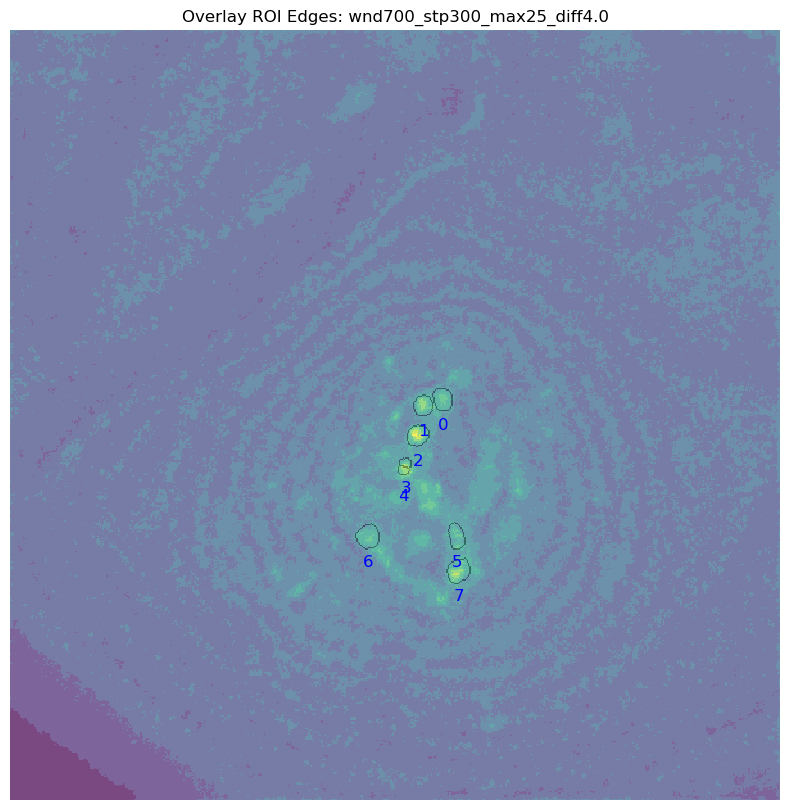

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max25_diff3.5.nc


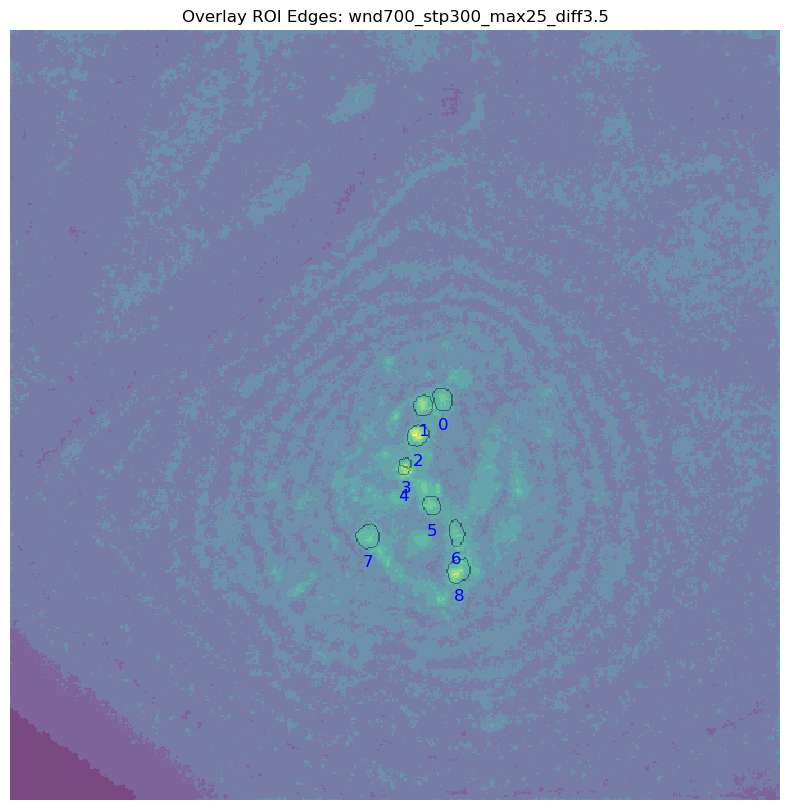

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max15_diff5.0.nc


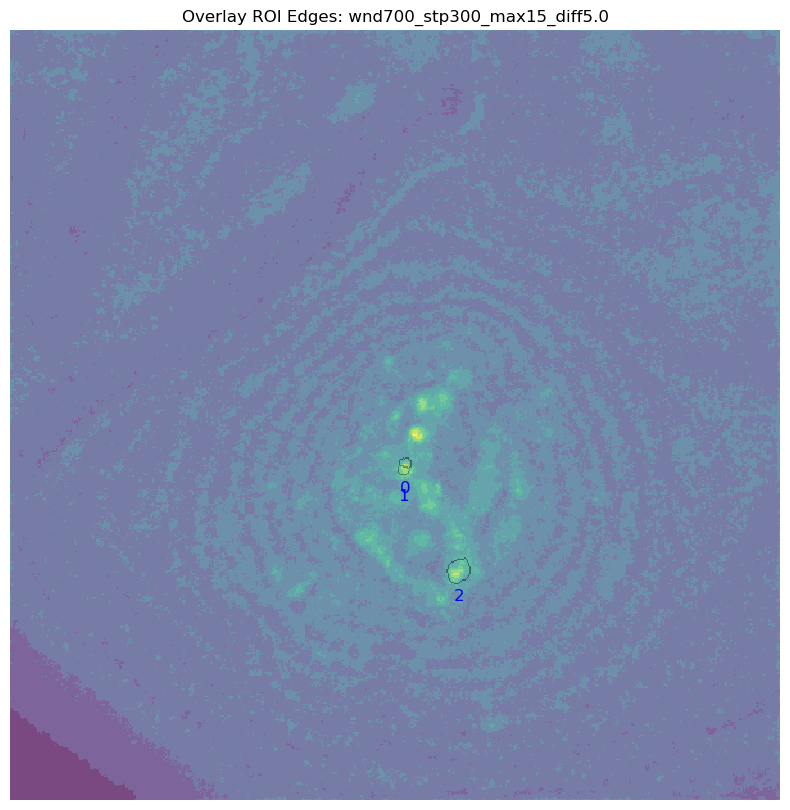

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max18_diff3.5.nc


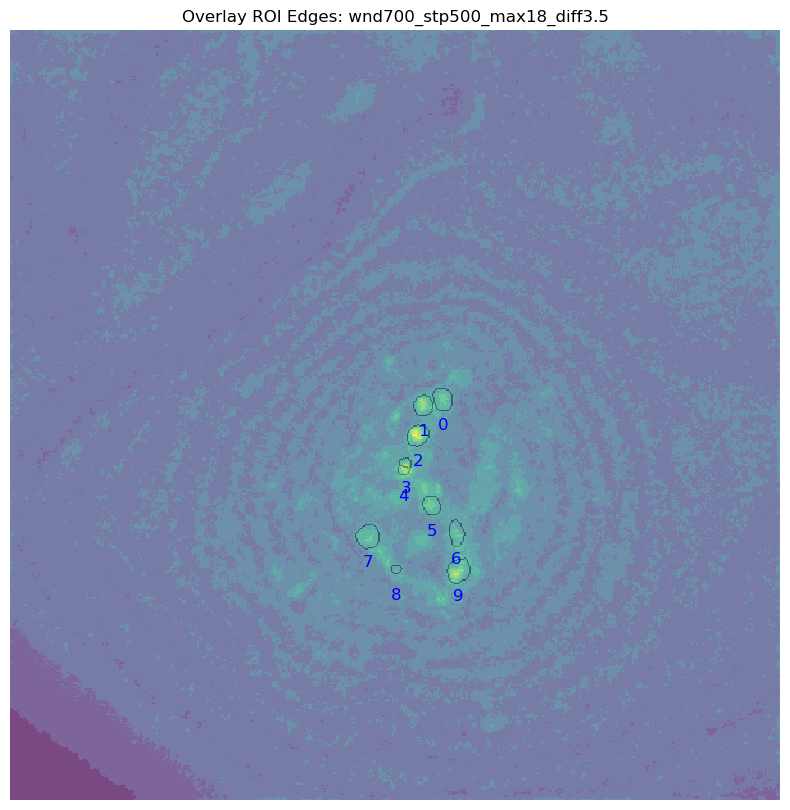

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max25_diff5.0.nc


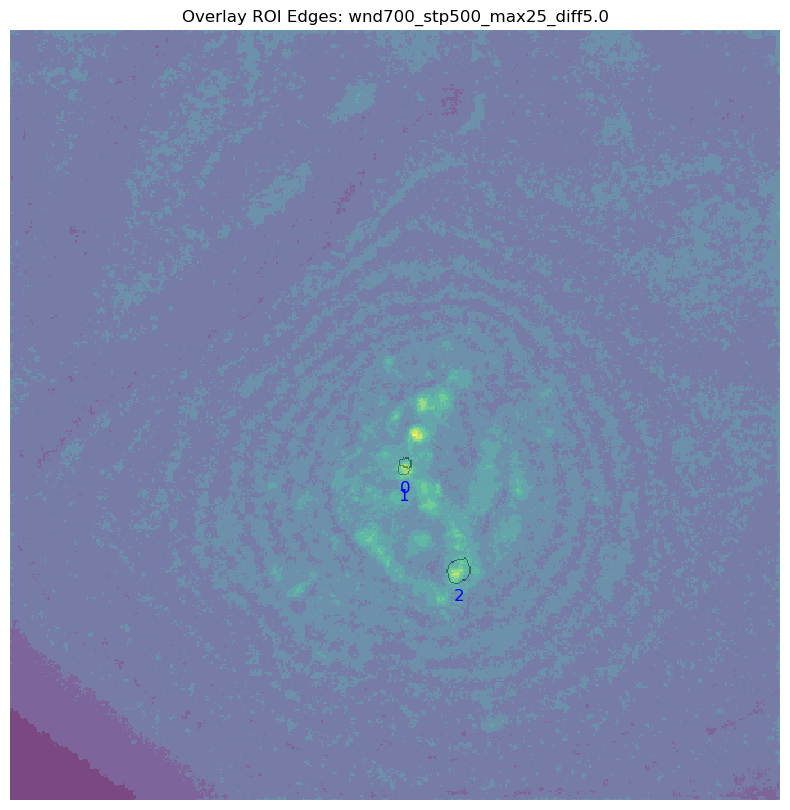

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max15_diff4.0.nc


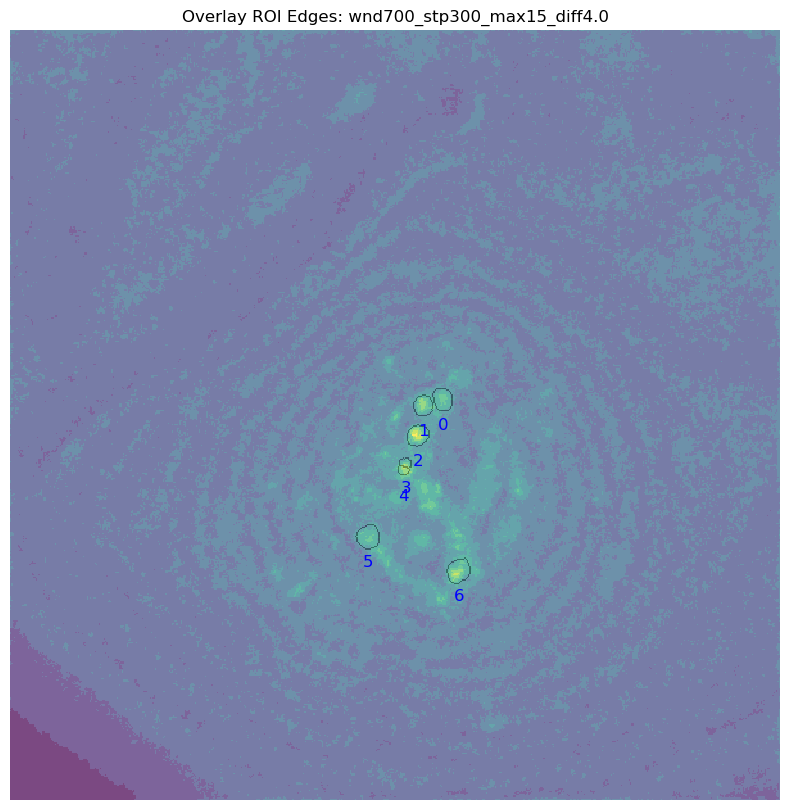

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max21_diff5.0.nc


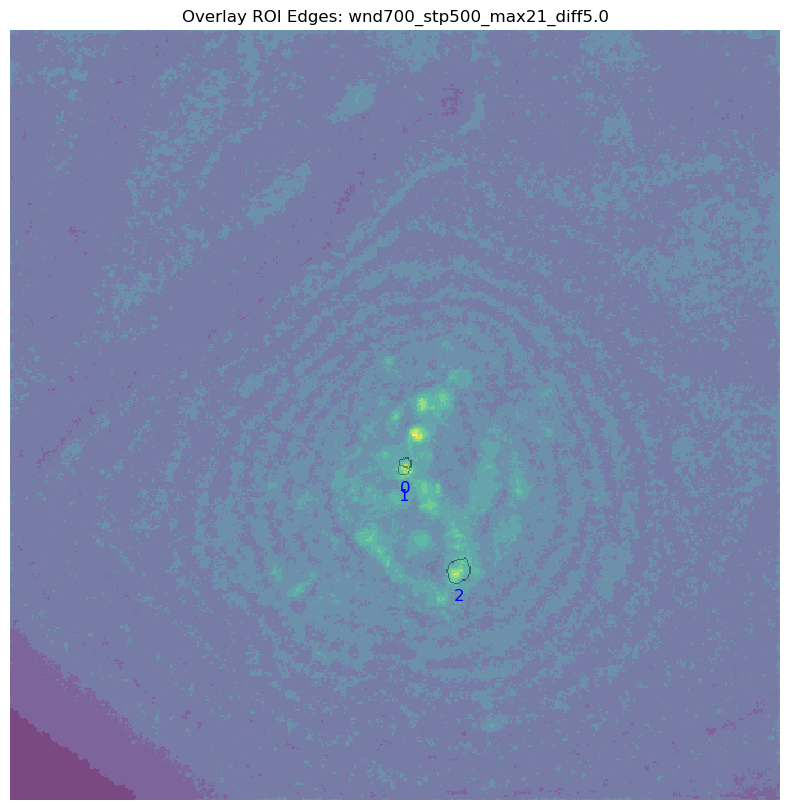

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max18_diff3.5.nc


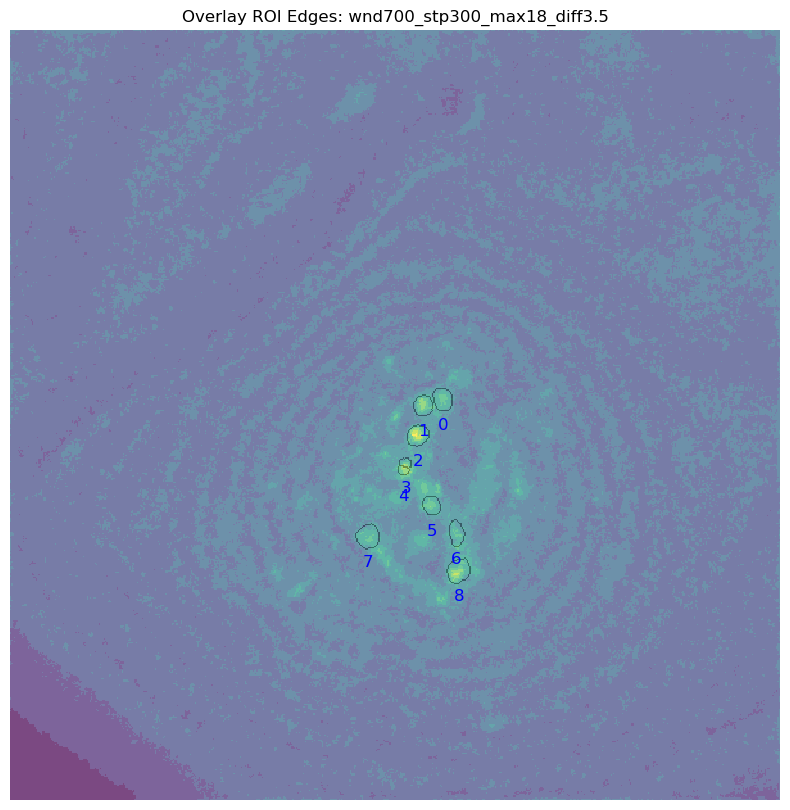

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max15_diff3.5.nc


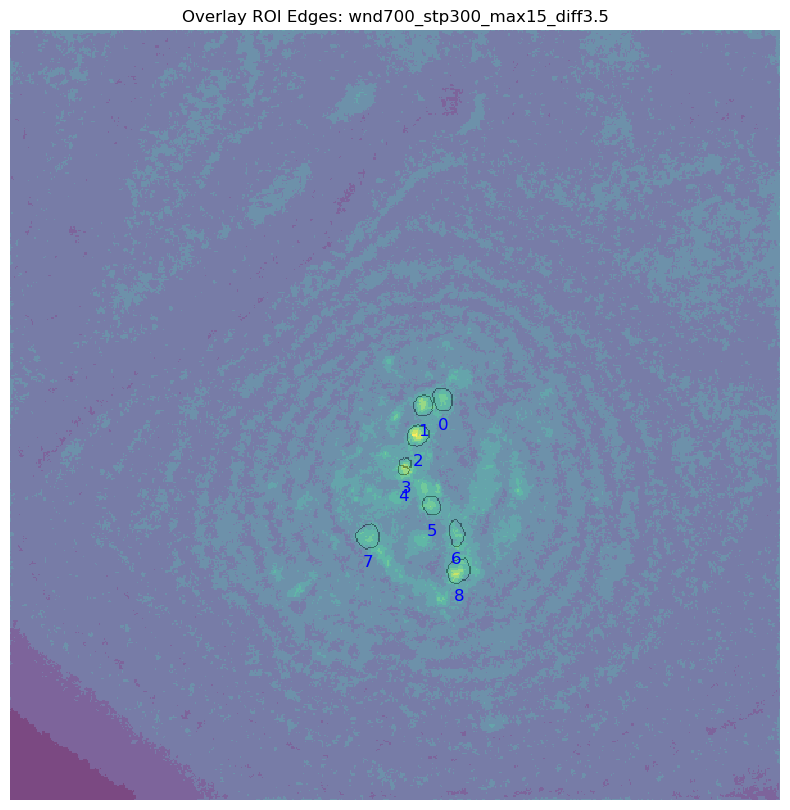

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max21_diff3.5.nc


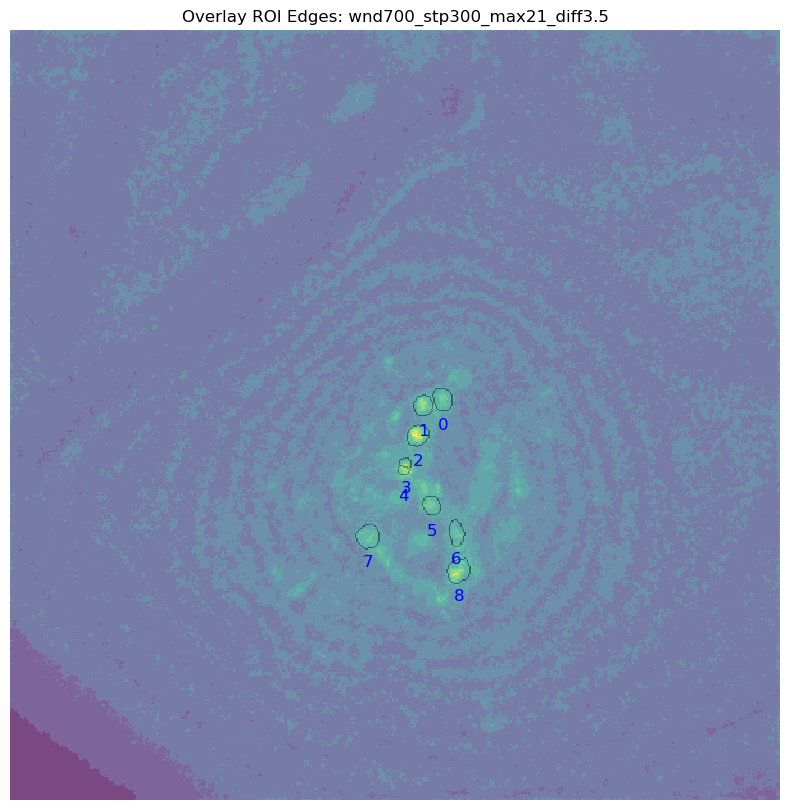

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp500_max25_diff4.0.nc


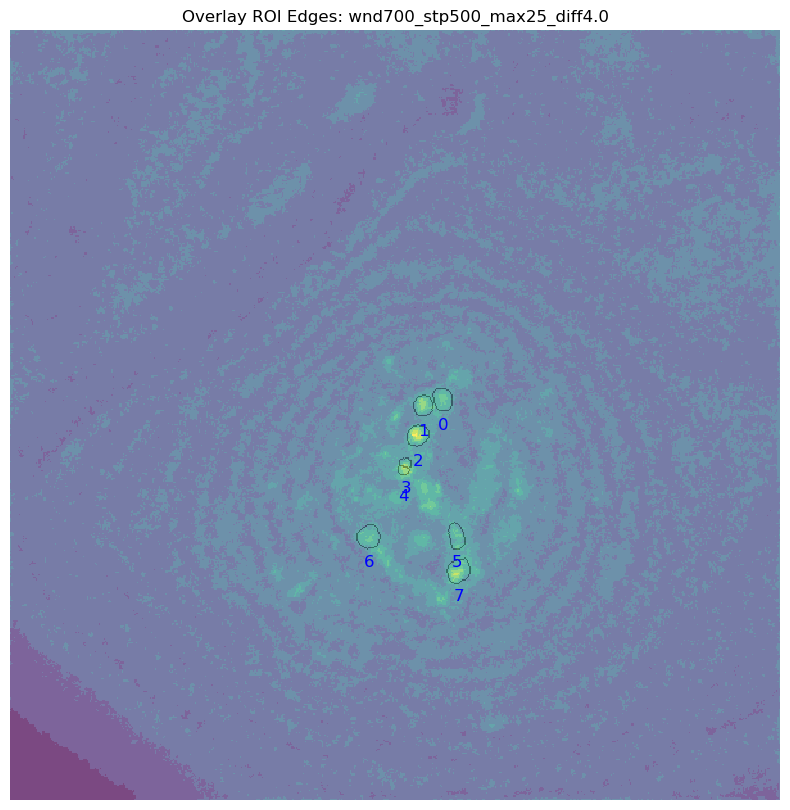

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd1500_stp700_max15_diff3.5_pnrauto.nc


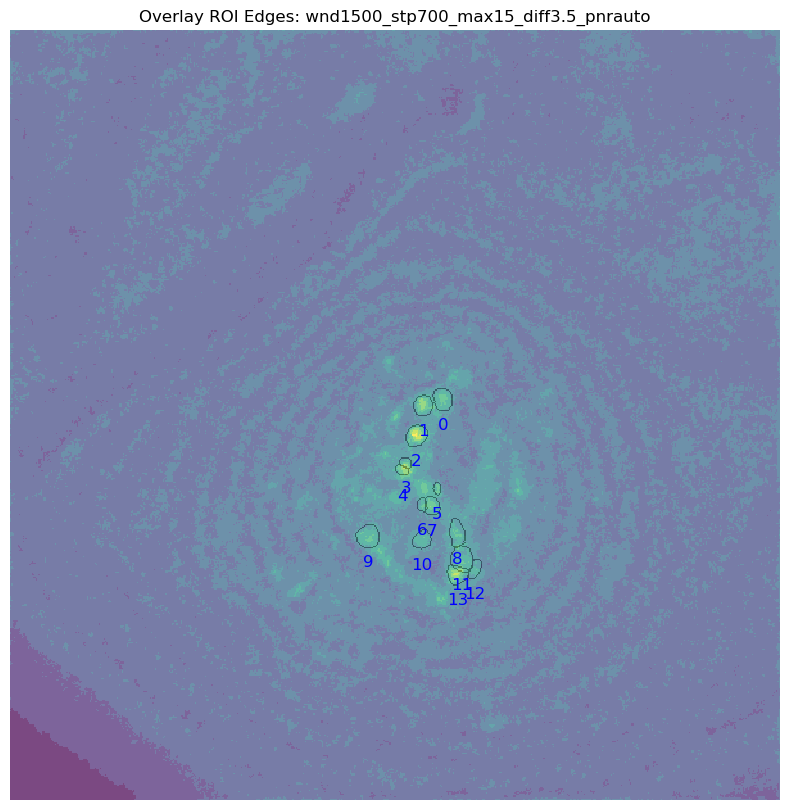

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp700_max15_diff4.0_pnrauto.nc


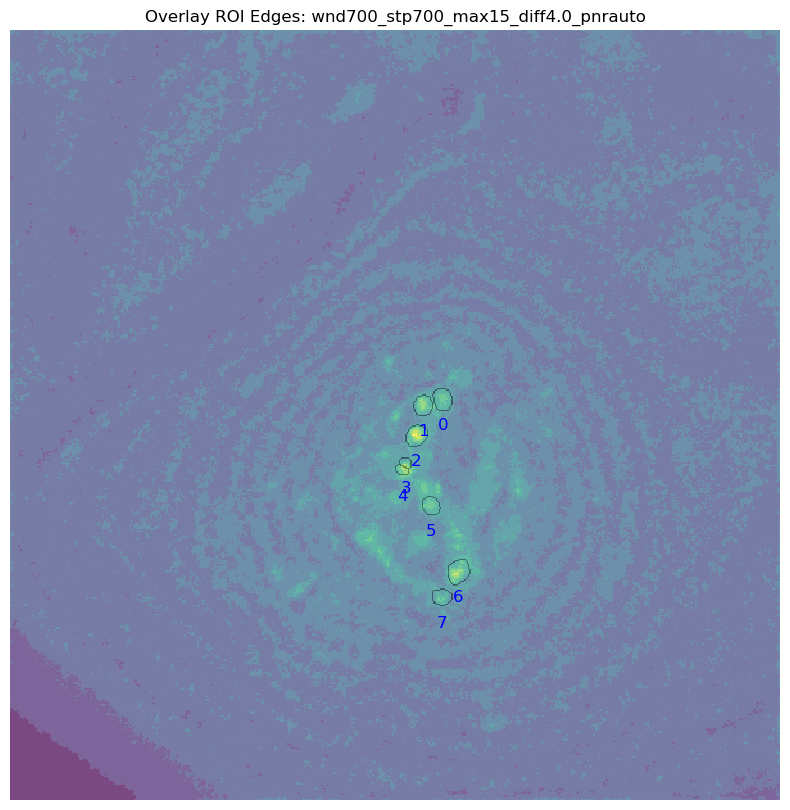

Processing: /data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope/minian_dataset_wnd700_stp300_max18_diff4.0.nc


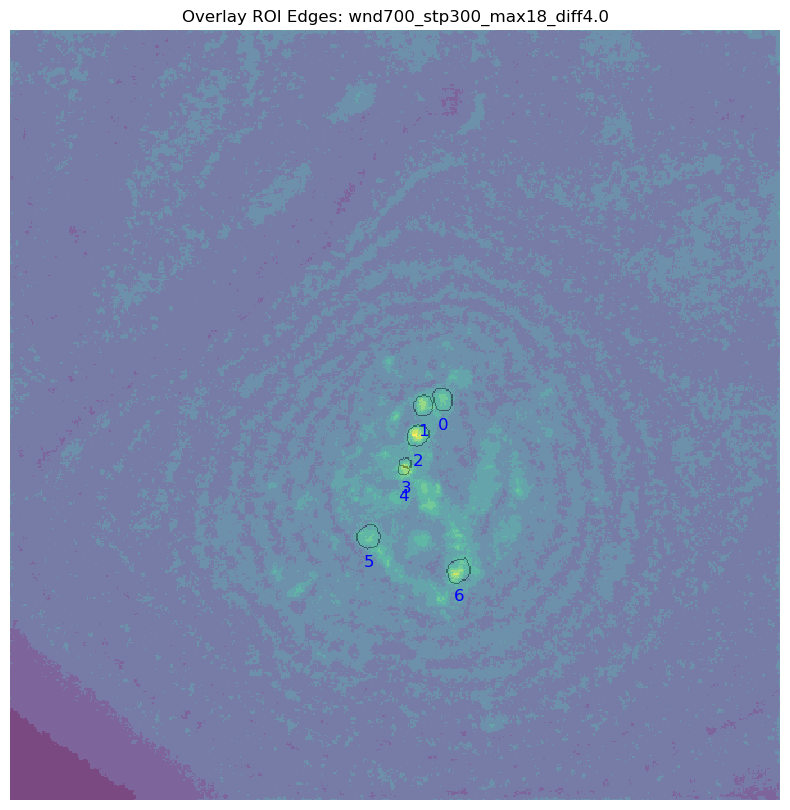

In [ ]:
import os
import glob
import shutil
import tempfile
import matplotlib.pyplot as plt
import sys
sys.path.append(os.path.abspath('../../'))
# Import your utility functions if needed
# from my_new_module import load_minian_data_specific, overlay_roi_edges
from utlis.Ca_tools.roi_spike_vis_utlis import load_minian_data, calculate_dff, overlay_all_roi_edges

import numpy as np
from scipy.ndimage import binary_erosion
import xarray as xr
import pandas as pd

def load_minian_data_specific(nc_path, timestamps_path):
    """
    Load minian data from a specific NetCDF file path, and load timestamps from a CSV path.
    
    Parameters
    ----------
    nc_path : str
        Full path to the .nc file to open.
    timestamps_path : str
        Path to the CSV file containing the time stamps.
    
    Returns
    -------
    data : xarray.Dataset
        The loaded dataset from the .nc file.
    timestamps : np.ndarray
        The 'Time Stamp (ms)' column from the timestamps CSV as a NumPy array.
    """
    if not os.path.isfile(nc_path):
        raise FileNotFoundError(f"NetCDF file not found: {nc_path}")
    if not os.path.isfile(timestamps_path):
        raise FileNotFoundError(f"Timestamps CSV not found: {timestamps_path}")
    
    # Open the dataset and load it fully into memory
    data = xr.open_dataset(nc_path)
    data = data.load()
    
    # Load timestamps from CSV
    timestamps_df = pd.read_csv(timestamps_path)
    if 'Time Stamp (ms)' not in timestamps_df.columns:
        raise ValueError("Expected column 'Time Stamp (ms)' in timestamps CSV.")
    
    return data, timestamps_df['Time Stamp (ms)'].values

def overlay_all_roi_edges_no_show(data, max_proj):
    """
    Overlay edges of all ROIs on the max projection image without calling plt.show().
    Returns the figure and axes so you can display or save as needed.
    
    Parameters
    ----------
    data : xarray.Dataset
        Must contain 'A': either a dense array [n_rois, width*height] or a sparse csc.
    max_proj : np.ndarray
        2D array (height, width) representing the max projection image.
    
    Returns
    -------
    fig : matplotlib.figure.Figure
    ax : matplotlib.axes.Axes
        The created figure and axes.
    """
    # 1) Convert 'A' to a dense array if it's sparse.
    A_var = data['A']
    if hasattr(A_var, 'values'):
        A_dense = A_var.values
    else:
        from scipy.sparse import csc_matrix
        A_dense = csc_matrix((A_var.data, A_var.indices, A_var.indptr),
                             shape=A_var.shape).toarray()
    
    # 2) Prepare an empty overlay array (same shape as max_proj).
    overlay_edges = np.zeros_like(max_proj, dtype=np.uint8)
    
    # 3) For each ROI, extract the mask, compute its edge, and add to overlay.
    n_rois = A_dense.shape[0]
    for roi in range(n_rois):
        roi_mask = A_dense[roi].reshape(max_proj.shape) > 0
        roi_edge = roi_mask ^ binary_erosion(roi_mask)
        overlay_edges += roi_edge.astype(np.uint8)
    
    # Clip to avoid intensities > 1
    overlay_edges = np.clip(overlay_edges, 0, 1)
    
    # 4) Create a new figure and axes, and plot the max projection.
    fig, ax = plt.subplots(figsize=(10, 10))
    # Using 'viridis' instead of 'gray'
    ax.imshow(max_proj, interpolation='nearest', cmap='viridis')
    
    # 5) Overlay the ROI edges in red with partial transparency.
    ax.imshow(overlay_edges, cmap='Reds', alpha=0.3, interpolation='nearest')
    
    # 6) Optionally label ROI centroids.
    for roi in range(n_rois):
        roi_mask = A_dense[roi].reshape(max_proj.shape) > 0
        coords = np.argwhere(roi_mask)
        if coords.size > 0:
            centroid = coords.mean(axis=0)
            ax.text(
                centroid[1], centroid[0] + 20, str(roi),
                color='blue', fontsize=12, ha='center', va='center'
            )
    
    # 7) Final styling.
    ax.set_title('Max Projection with All ROI Edges Overlay')
    ax.axis('off')
    
    # 8) Return the figure and axes.
    return fig, ax

# Use your real session directory path.
session_dir = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope"
nc_files = glob.glob(os.path.join(session_dir, "minian_dataset_*.nc"))

if not nc_files:
    print("No output files found in the session directory.")
else:
    print(f"Found {len(nc_files)} output files:")
    for f in nc_files:
        print(f)

mini_timestamps = os.path.join(session_dir, 'timeStamps.csv')

# Remove previous overlay PNG files (trash) before processing new ones.
old_overlay_files = glob.glob(os.path.join(session_dir, "overlay_*.png"))
for old_file in old_overlay_files:
    try:
        os.remove(old_file)
        print(f"Removed old overlay file: {old_file}")
    except Exception as e:
        print(f"Error removing {old_file}: {e}")

# Set display_only to True to display the overlays in the notebook (won't save PNG files).
# Set to False if you want to save the images instead.
display_only = True

for nc_file in nc_files:
    print("Processing:", nc_file)
    
    # Copy each file to a temporary file in the system's temporary directory.
    temp_nc = os.path.join(tempfile.gettempdir(), os.path.basename(nc_file))
    shutil.copy2(nc_file, temp_nc)
    
    # Load the data (fully loaded into memory) and timestamps.
    data, ts = load_minian_data_specific(temp_nc, mini_timestamps)
    
    # Extract the max projection.
    max_proj = data['max_proj'].values
    
    # Create the overlay figure (without automatically displaying it).
    fig, ax = overlay_all_roi_edges_no_show(data, max_proj)
    
    # Update the title with an ID derived from the filename.
    combination_id = os.path.basename(nc_file).replace("minian_dataset_", "").replace(".nc", "")
    title = "_".join(session_dir.split("/")[-5:-2])
    ax.set_title(title + combination_id) #"Overlay ROI Edges: "
    
    if display_only:
        # For VSCode Jupyter Notebook, display the figure inline.
        plt.show()
    else:
        # Save the figure if not in display-only mode.
        output_fig = os.path.join(session_dir, f"overlay_{combination_id}.png")
        fig.savefig(output_fig)
        print(f"Saved overlay to: {output_fig}")
    
    plt.close(fig)
    os.remove(temp_nc)


In [12]:
# haven't tested, but eventually very good for session clean ups...
import os
import csv

def cleanup_session(session_dir, keep_combination):
    """
    Deletes all output files in session_dir except the one matching keep_combination.
    
    Parameters:
        session_dir (str): The session directory.
        keep_combination (str): The combination identifier to keep 
                                (e.g., "wnd700_stp700_max25_diff4.0_pnrauto").
    """
    log_file = os.path.join(session_dir, "param_search_log.csv")
    if not os.path.exists(log_file):
        print("Log file not found!")
        return

    with open(log_file, "r") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            combination = row["combination"]
            output_file = row["result_file"]
            if combination != keep_combination:
                if os.path.exists(output_file):
                    os.remove(output_file)
                    print(f"Removed: {output_file}")
                else:
                    print(f"Output file not found for combination {combination}.")

    print("Cleanup complete.")


# Example usage:
session_dir = "/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/20241224PMCLE1/customEntValHere/2025_02_13/11_07_37/My_V4_Miniscope"
keep_combination = "wnd1500_stp700_max15_diff3.5_pnrauto" #"wnd700_stp700_max25_diff4.0_pnrauto"  # Update with the chosen identifier
cleanup_session(session_dir, keep_combination)


Output file not found for combination wnd700_stp300_max15_diff3.5.
Output file not found for combination wnd700_stp300_max15_diff4.0.
Output file not found for combination wnd700_stp300_max15_diff5.0.
Output file not found for combination wnd700_stp300_max18_diff3.5.
Output file not found for combination wnd700_stp300_max18_diff4.0.
Output file not found for combination wnd700_stp300_max18_diff5.0.
Output file not found for combination wnd700_stp300_max21_diff3.5.
Output file not found for combination wnd700_stp300_max21_diff4.0.
Output file not found for combination wnd700_stp300_max21_diff5.0.
Output file not found for combination wnd700_stp300_max25_diff3.5.
Output file not found for combination wnd700_stp300_max25_diff4.0.
Output file not found for combination wnd700_stp300_max25_diff5.0.
Output file not found for combination wnd700_stp500_max15_diff3.5.
Output file not found for combination wnd700_stp500_max15_diff4.0.
Output file not found for combination wnd700_stp500_max15_diff